In [1]:
import warnings; 
warnings.simplefilter('ignore')

## Install and Import Dependencies

In [39]:
# Python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import numpy as np


In [40]:
from prophet import Prophet

In [89]:
df = pd.read_csv('seattle-weather.csv')

In [90]:
df.describe()

precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000

In [91]:
df.shape

(1461, 6)

In [92]:
df.date = pd.to_datetime(df.date)

In [93]:
df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [94]:
df.head()

date  precipitation  temp_max  temp_min  wind  weather
0 2012-01-01            0.0      12.8       5.0   4.7  drizzle
1 2012-01-02           10.9      10.6       2.8   4.5     rain
2 2012-01-03            0.8      11.7       7.2   2.3     rain
3 2012-01-04           20.3      12.2       5.6   4.7     rain
4 2012-01-05            1.3       8.9       2.8   6.1     rain

Adding a midtempreture column that is the average of Min and Max. 

In [95]:
df['mid_temp'] = (df['temp_max'] + df['temp_min'])/1

In [96]:
df.head()

date  precipitation  temp_max  temp_min  wind  weather  mid_temp
0 2012-01-01            0.0      12.8       5.0   4.7  drizzle      17.8
1 2012-01-02           10.9      10.6       2.8   4.5     rain      13.4
2 2012-01-03            0.8      11.7       7.2   2.3     rain      18.9
3 2012-01-04           20.3      12.2       5.6   4.7     rain      17.8
4 2012-01-05            1.3       8.9       2.8   6.1     rain      11.7

In [97]:
df = df.drop(columns = ['weather','temp_max', 'temp_min'], axis =1)

In [98]:
df.columns

Index(['date', 'precipitation', 'wind', 'mid_temp'], dtype='object')

In [99]:
#Parse the date column

from datetime import datetime, date 
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

# Data Visualization

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   wind           1461 non-null   float64       
 3   mid_temp       1461 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 45.8 KB


## Features:
- Precipitation
- wind
## Target: 
- mid_temp'

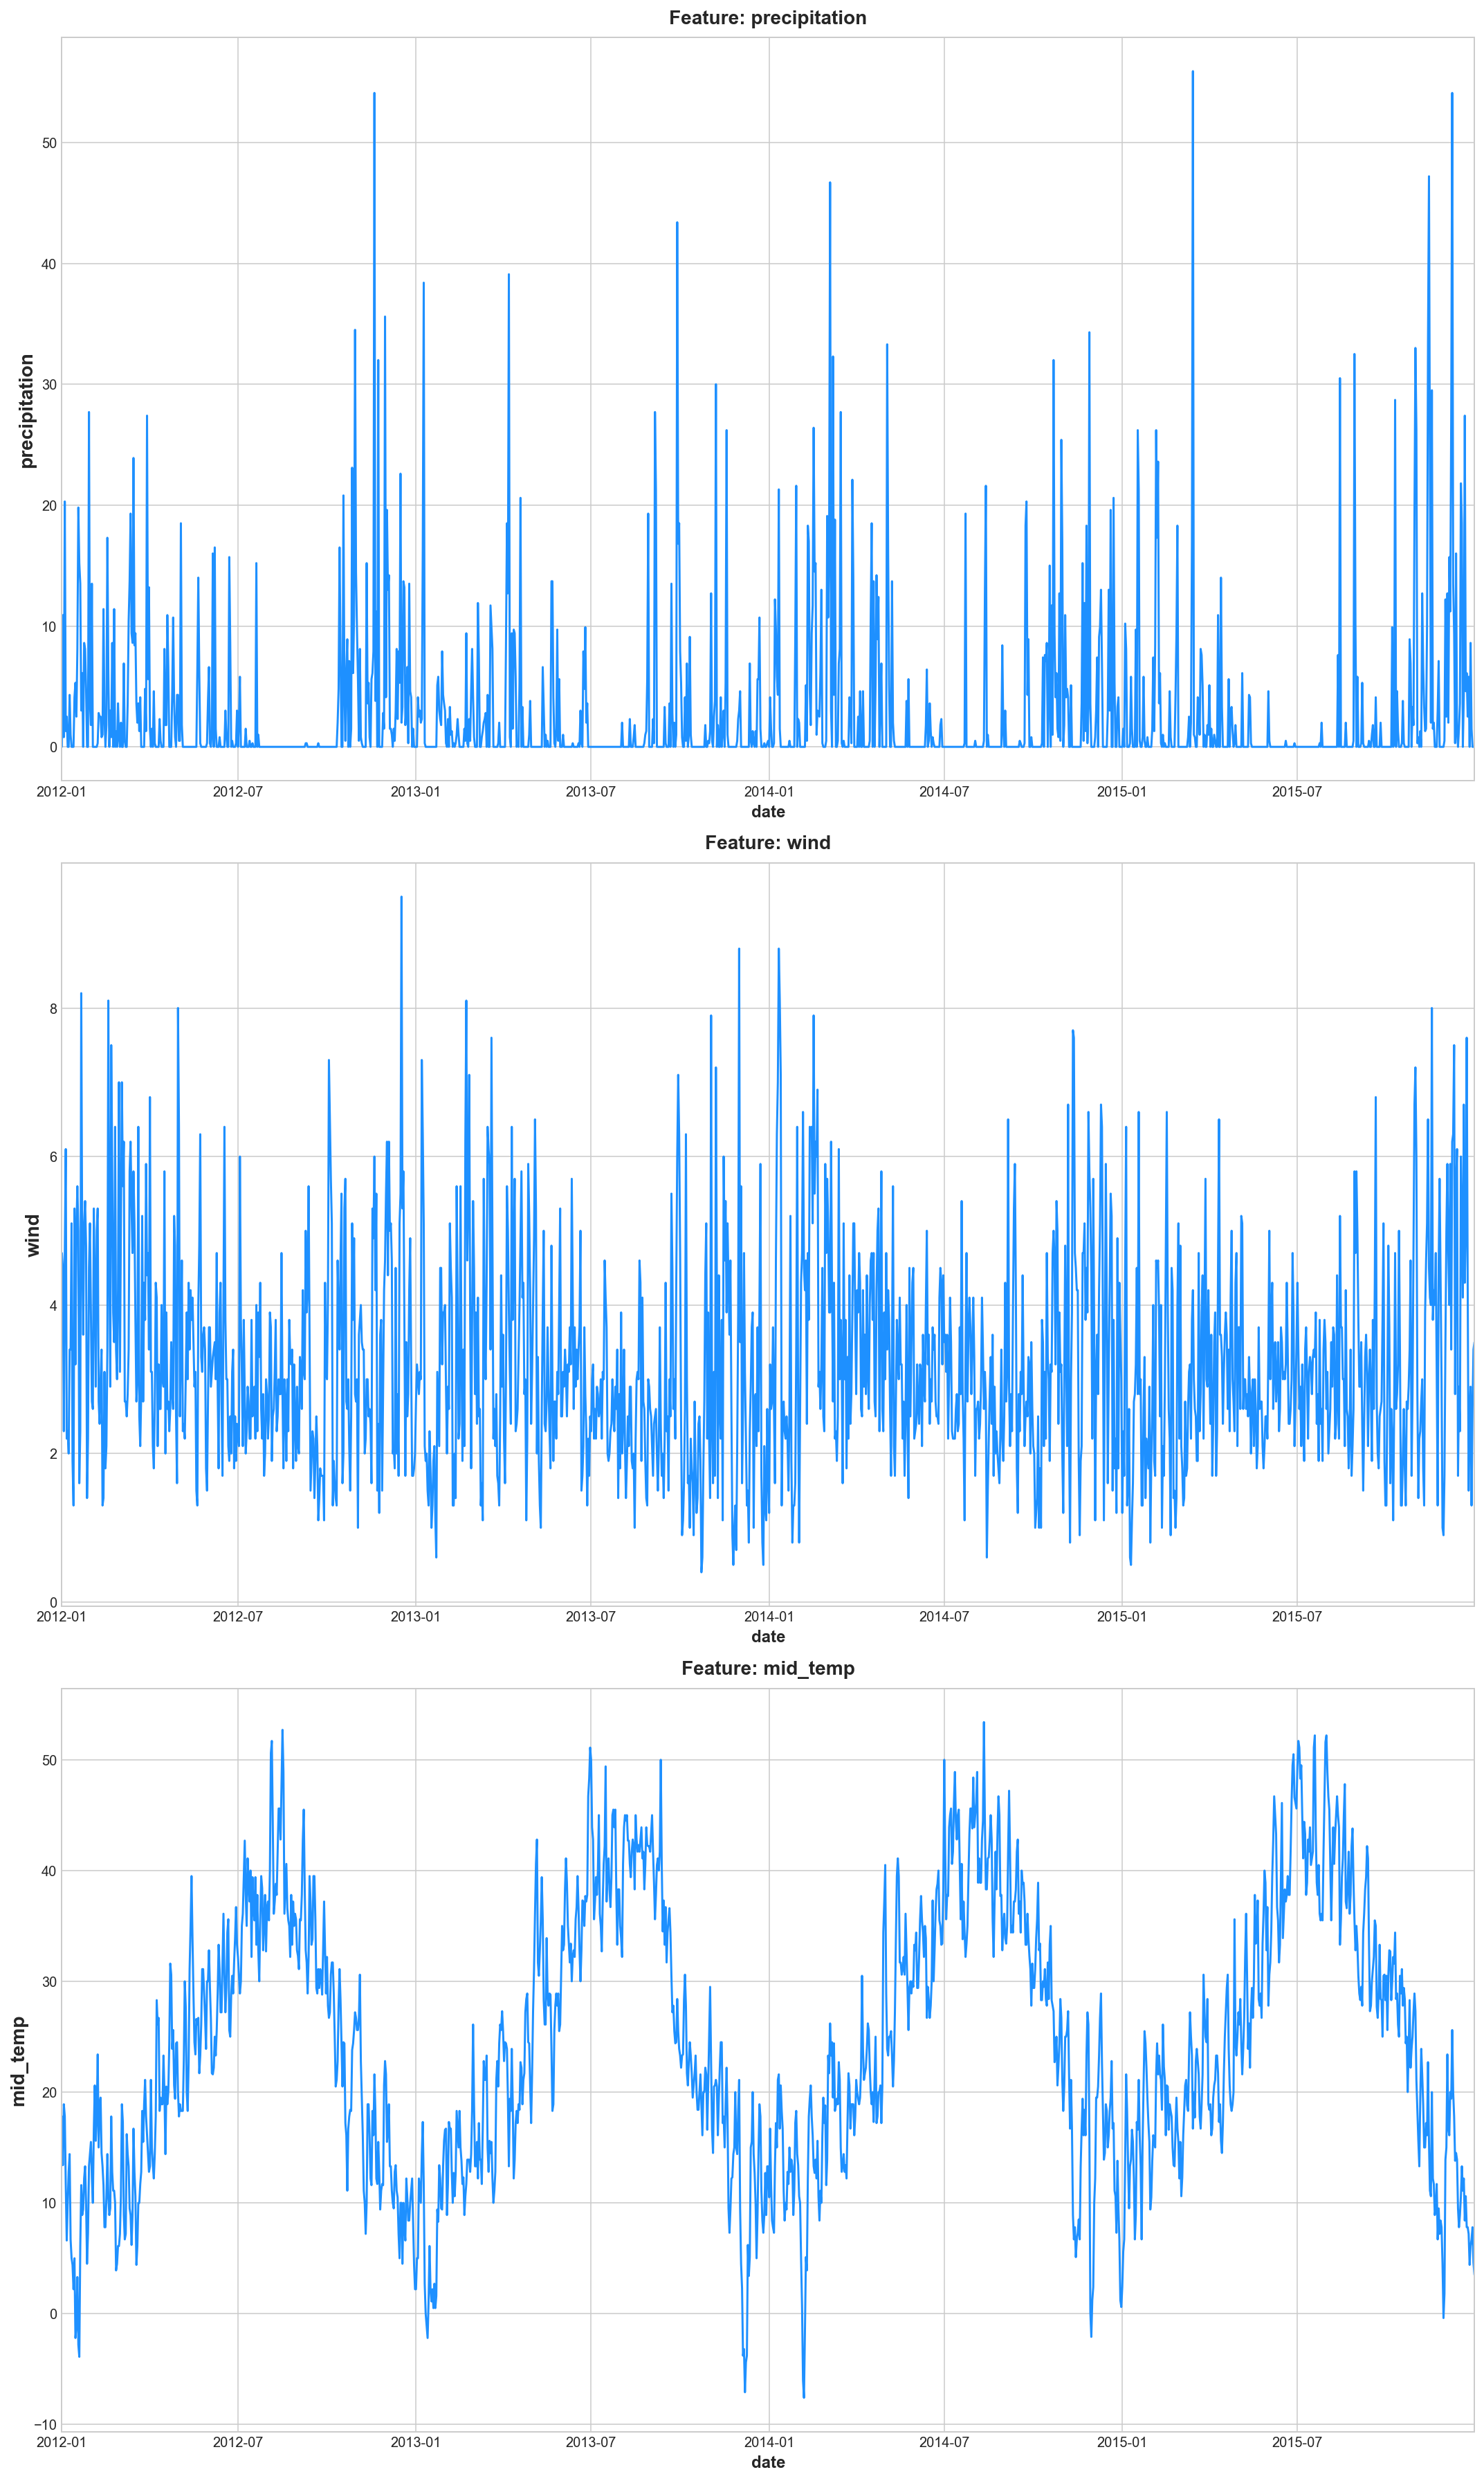

In [102]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([datetime(2012, 1, 1), datetime(2015, 12, 31)])  

## Check the Chronological Order 

Chronological Order and Equidistant Timestamps
The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [103]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

date  delta
0 2012-01-01    NaT
1 2012-01-02 1 days
2 2012-01-03 1 days
3 2012-01-04 1 days
4 2012-01-05 1 days

In [104]:
df['delta'].sum(), df['delta'].count()

(Timedelta('1460 days 00:00:00'), 1460)

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

In [107]:
df.columns

Index(['date', 'precipitation', 'wind', 'mid_temp', 'delta'], dtype='object')

## Smoothing Data / Resampling

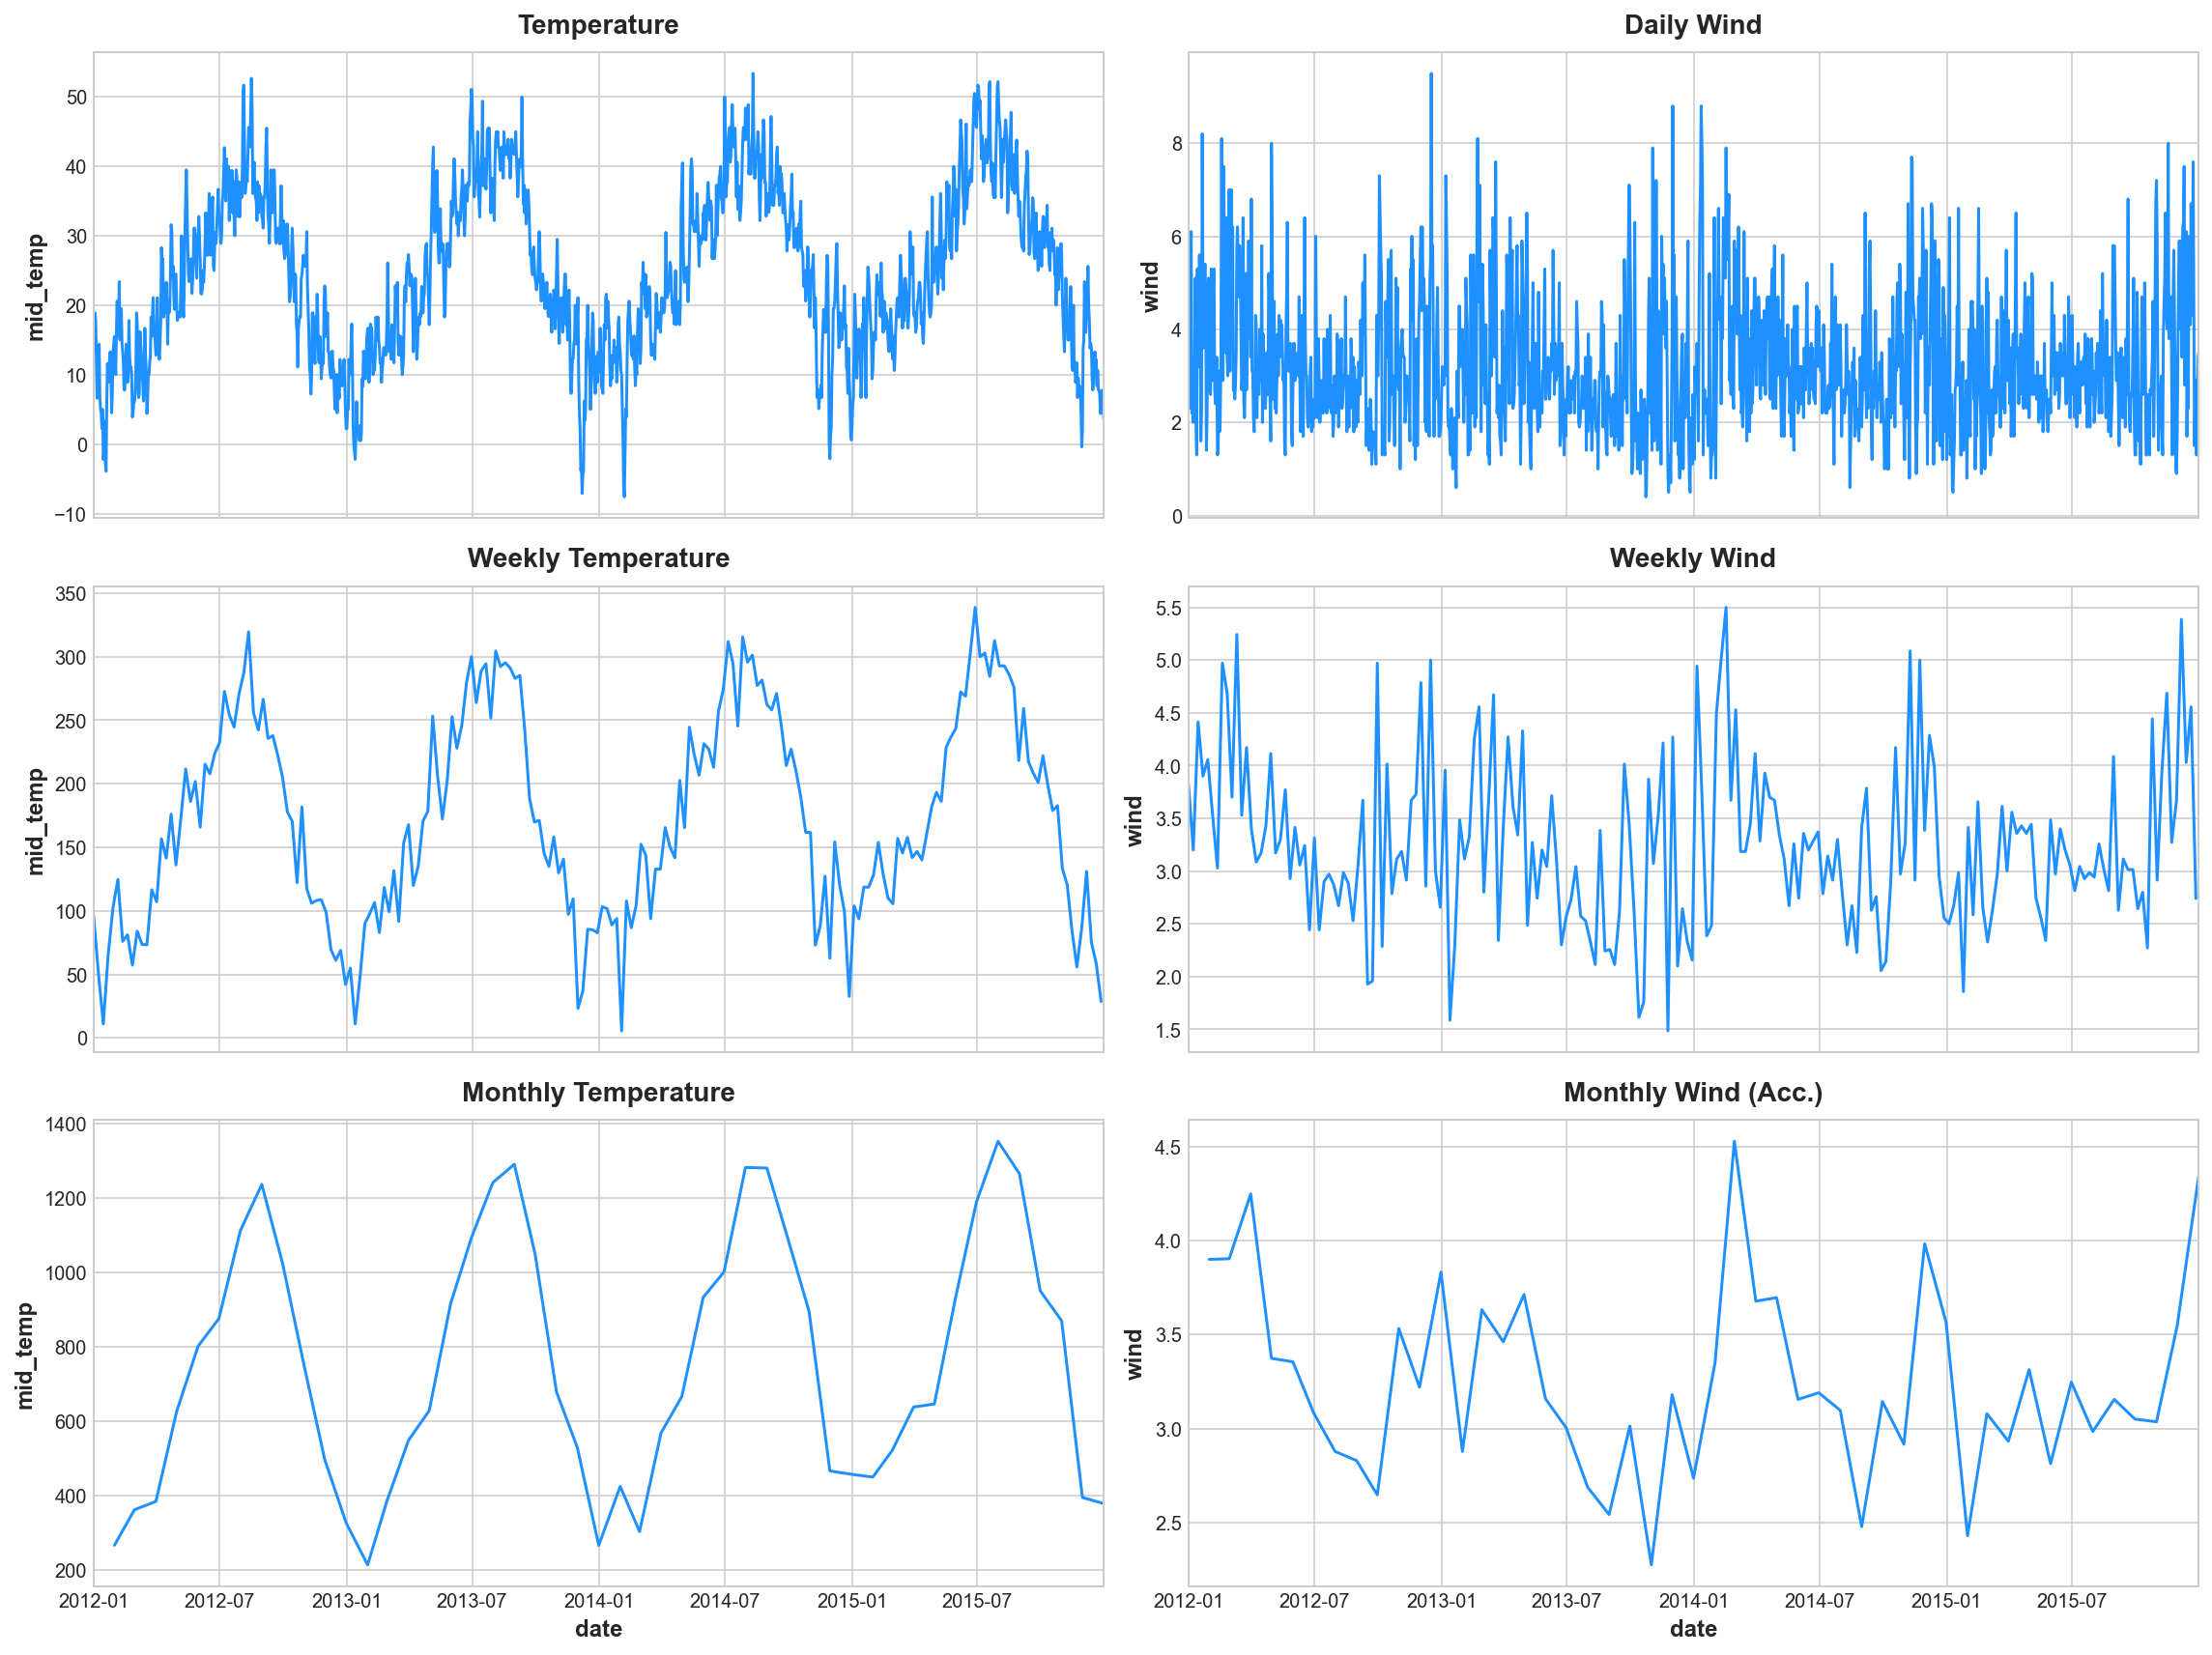

In [109]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['date'], df['mid_temp'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Temperature', fontsize=14)

resampled_df = df[['date','mid_temp']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['mid_temp'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Temperature', fontsize=14)

resampled_df = df[['date','mid_temp']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['mid_temp'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Temperature', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2012, 1, 1), date(2015, 12, 31)])



    
    
sns.lineplot(df['date'], df['wind'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Wind', fontsize=14)

resampled_df = df[['date','wind']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['wind'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Wind', fontsize=14)

resampled_df = df[['date','wind']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['wind'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Wind (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2012, 1, 1), date(2015, 12, 31)])
    
    

    
    

In [110]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date',
                 'mid_temp', 
                 'wind',
                 'precipitation']].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

# Stationary

There are three different approaches:

- visually: plot time series and check for trends or seasonality
- basic statistics: split time series and compare the mean and variance of each partition
- statistical test: Augmented Dickey Fuller test

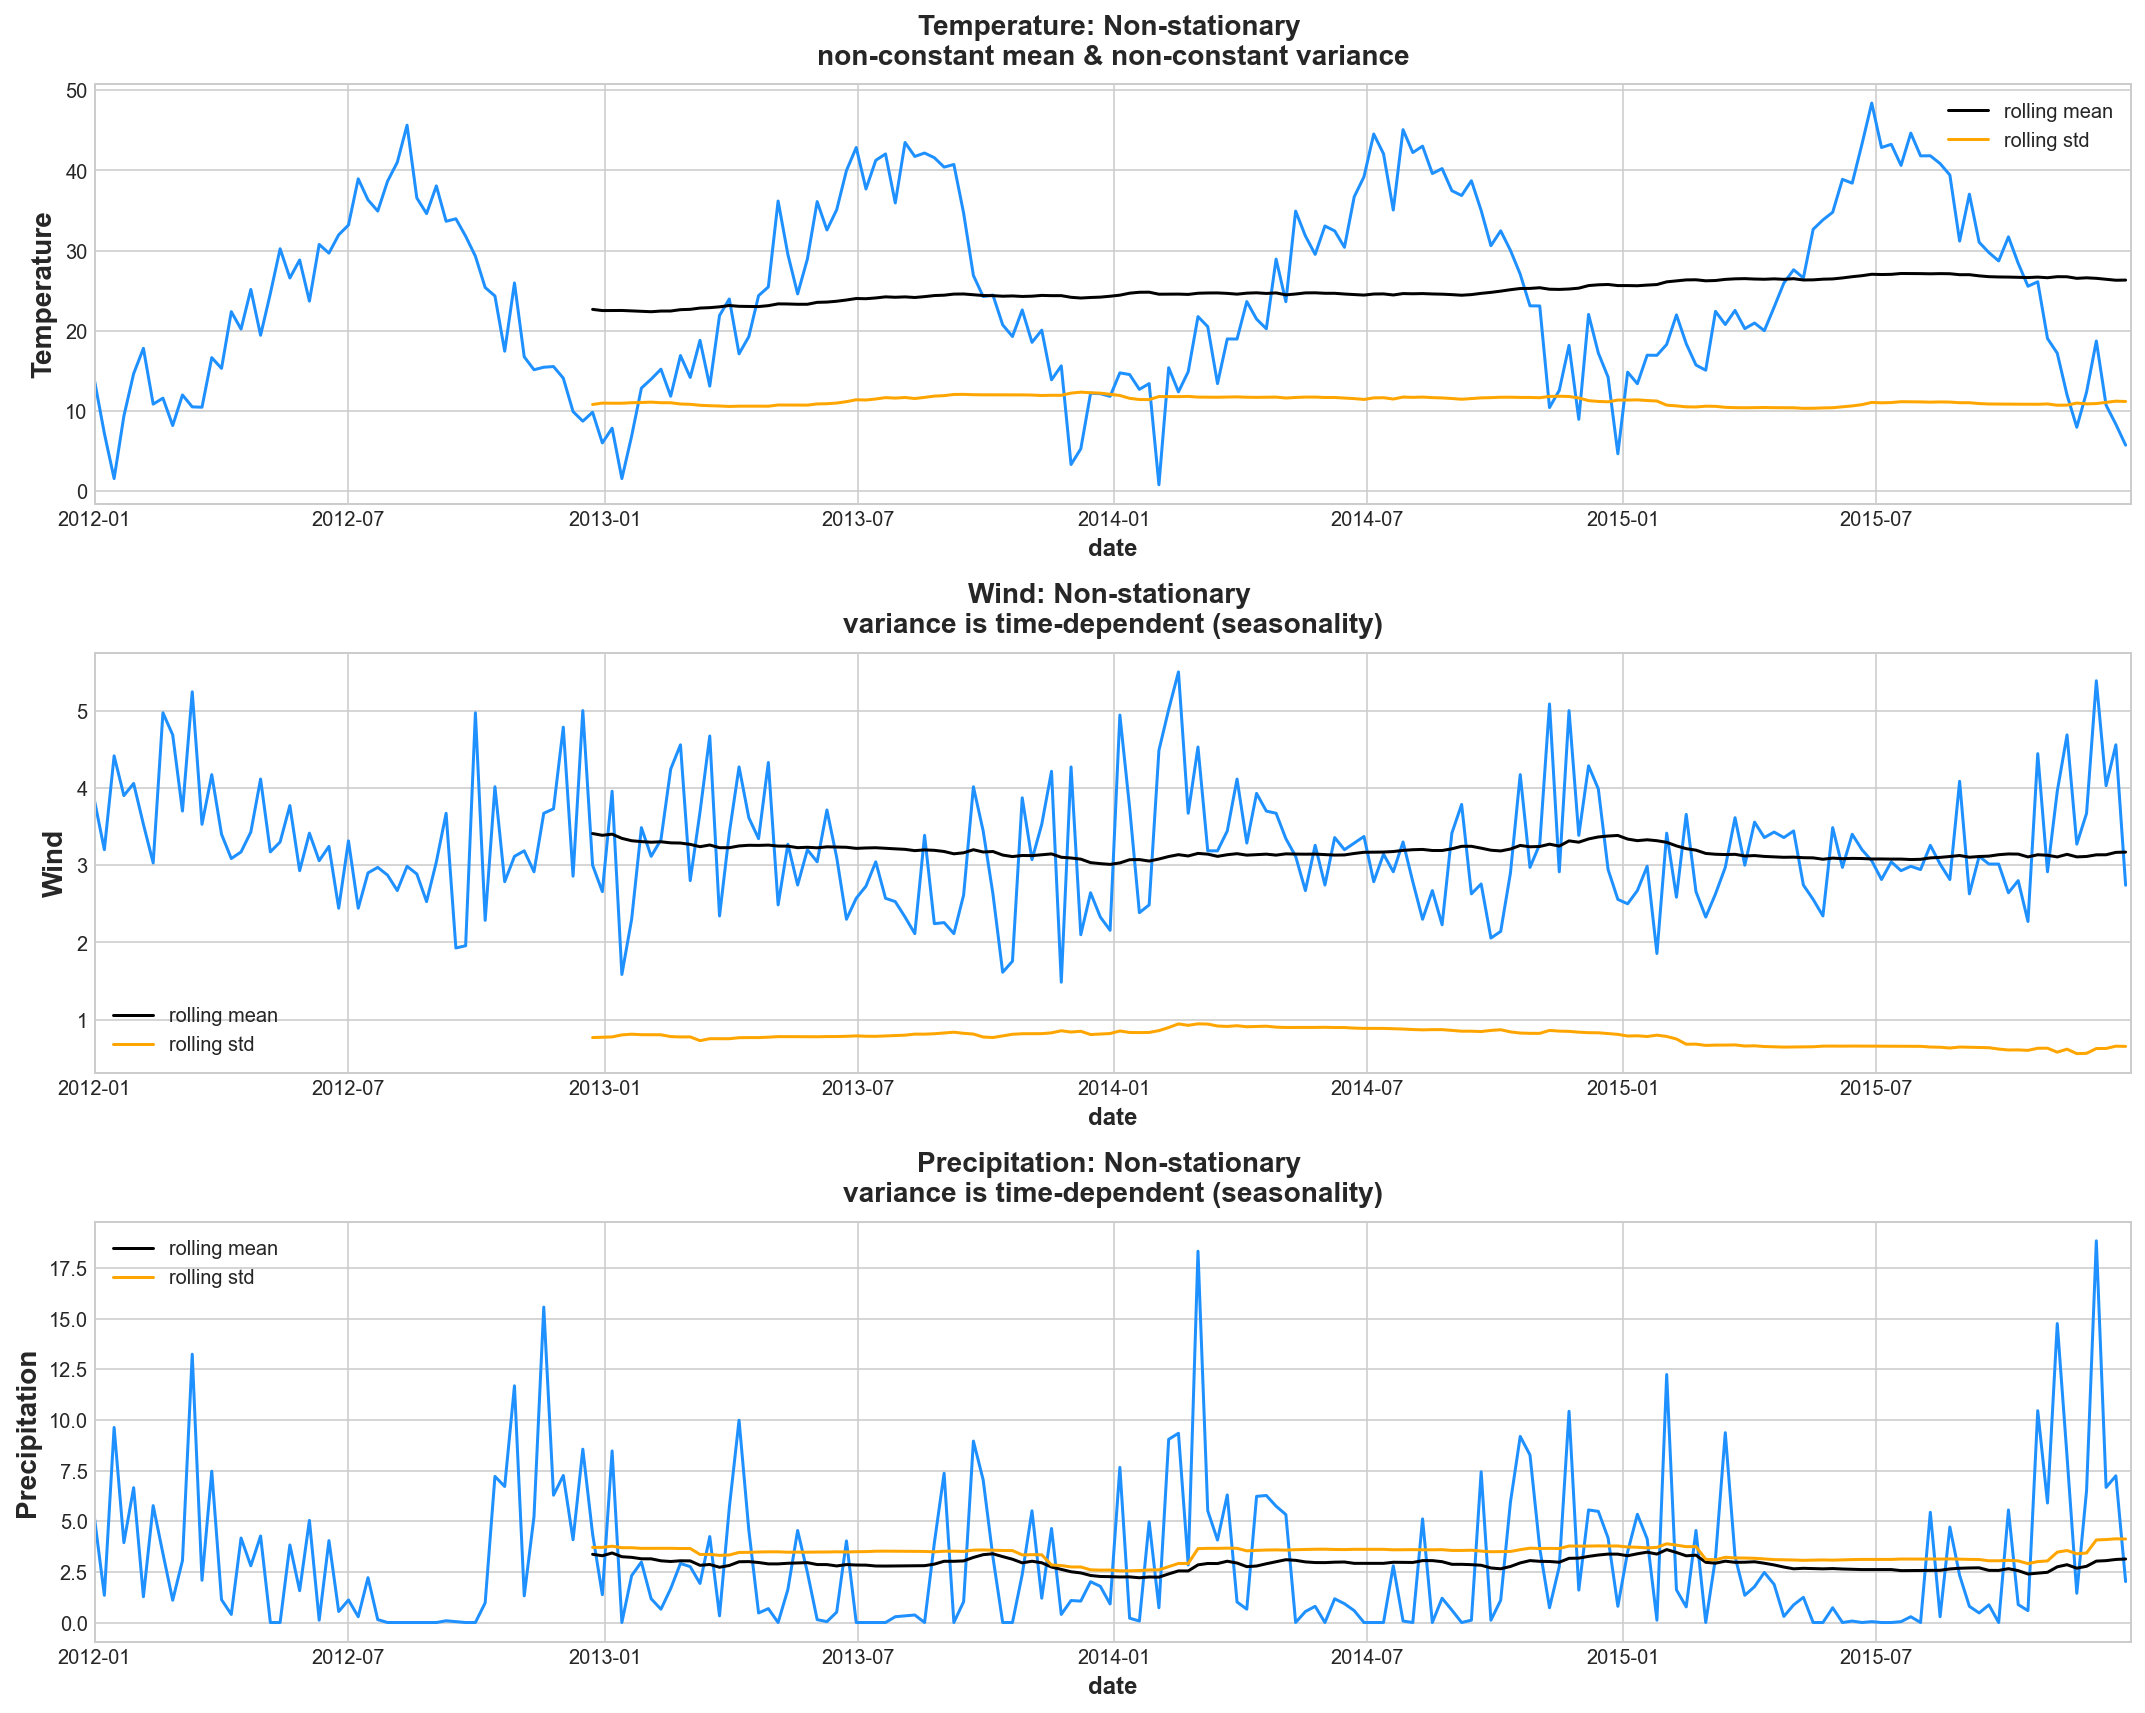

In [116]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['mid_temp'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['mid_temp'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['mid_temp'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Temperature: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Temperature', fontsize=14)
ax[0].set_xlim([date(2012, 1, 1), date(2015, 12, 31)])

sns.lineplot(x=df['date'], y=df['wind'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['wind'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['wind'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Wind: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Wind', fontsize=14)
ax[1].set_xlim([date(2012, 1, 1), date(2015, 12, 31)])


sns.lineplot(x=df['date'], y=df['precipitation'], ax=ax[2], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['precipitation'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['precipitation'].rolling(rolling_window).std(), ax=ax[2], color='orange', label='rolling std')
ax[2].set_title('Precipitation: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[2].set_ylabel(ylabel='Precipitation', fontsize=14)
ax[2].set_xlim([date(2012, 1, 1), date(2015, 12, 31)])
plt.tight_layout()
plt.show()

In this visual check, we can see that the features don't have constant mean and std, but they are close to it.

Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

Y
t
=
α
Y
t
−
1
+
β
X
e
+
ϵ
 
where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

## Augmented Dickey-Fuller (ADF)

Unit Root Test
Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

Y
t
=
α
Y
t
−
1
+
β
X
e
+
ϵ
 
where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

2.3.1 Augmented Dickey-Fuller (ADF)

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [118]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['mid_temp'].values)
result

(-6.128600565007404,
 8.509251945319535e-08,
 13,
 195,
 {'1%': -3.464337030867007,
  '5%': -2.876478799035722,
  '10%': -2.574733103221565},
 1105.1079018226883)

Now, we are going to check for each variable:

The p-value is less than 0.05
Check the range of the ADF statistic compared with critical_values

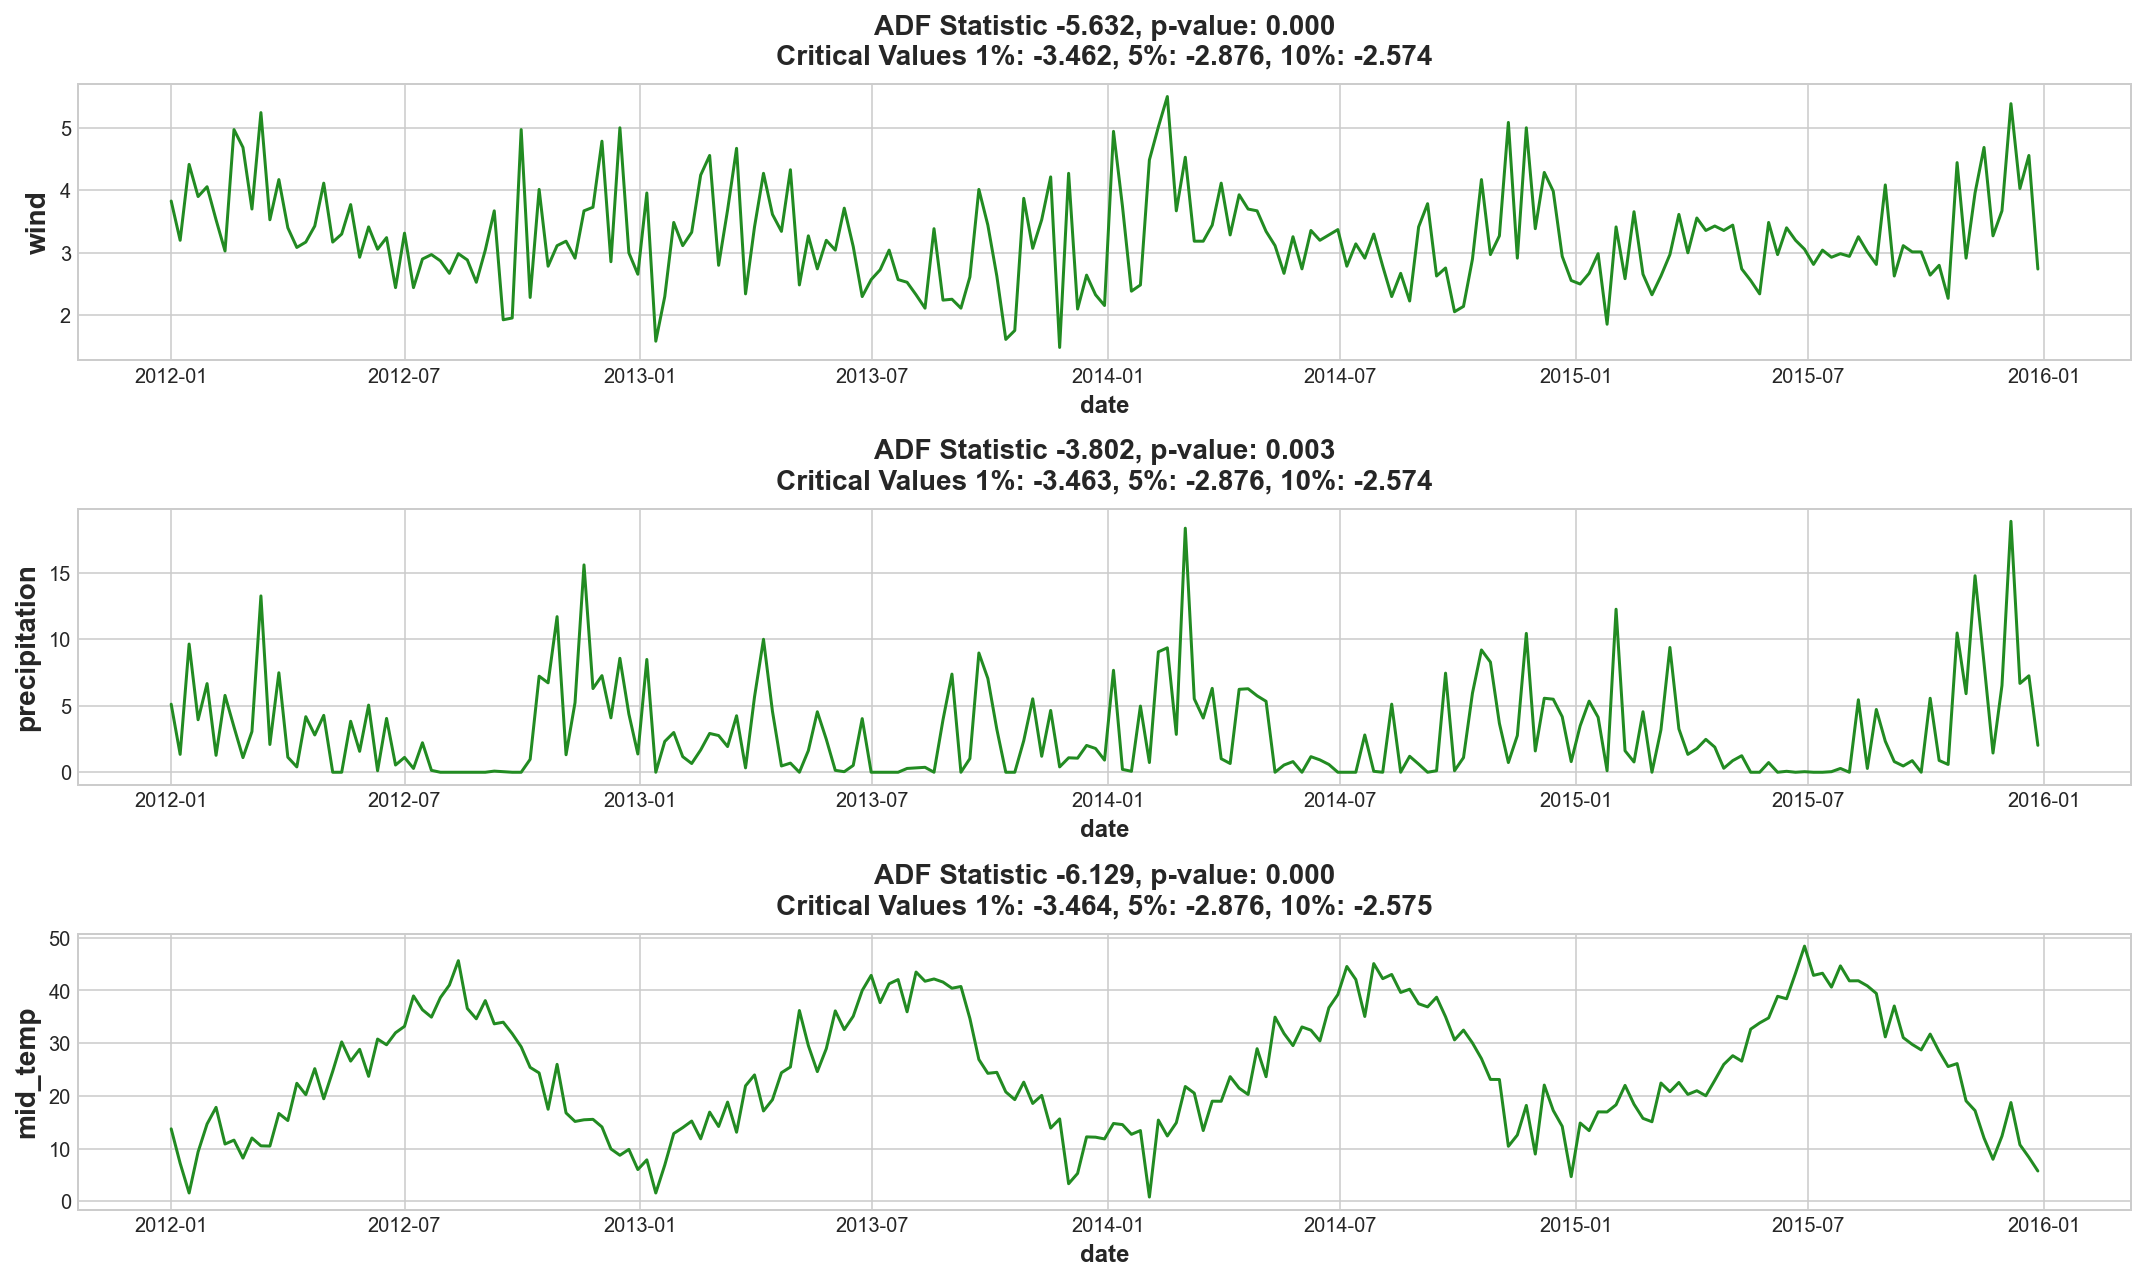

In [122]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['wind'].values, 'wind', ax[0])
visualize_adfuller_results(df['precipitation'].values, 'precipitation', ax[1])
visualize_adfuller_results(df['mid_temp'].values, 'mid_temp', ax[2])



plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

Transformation: e.g. log or square root to stabilize non-constant variance
Differencing: subtracts the current value from the previous

## Transforming

<Axes: xlabel='mid_temp_log', ylabel='Density'>

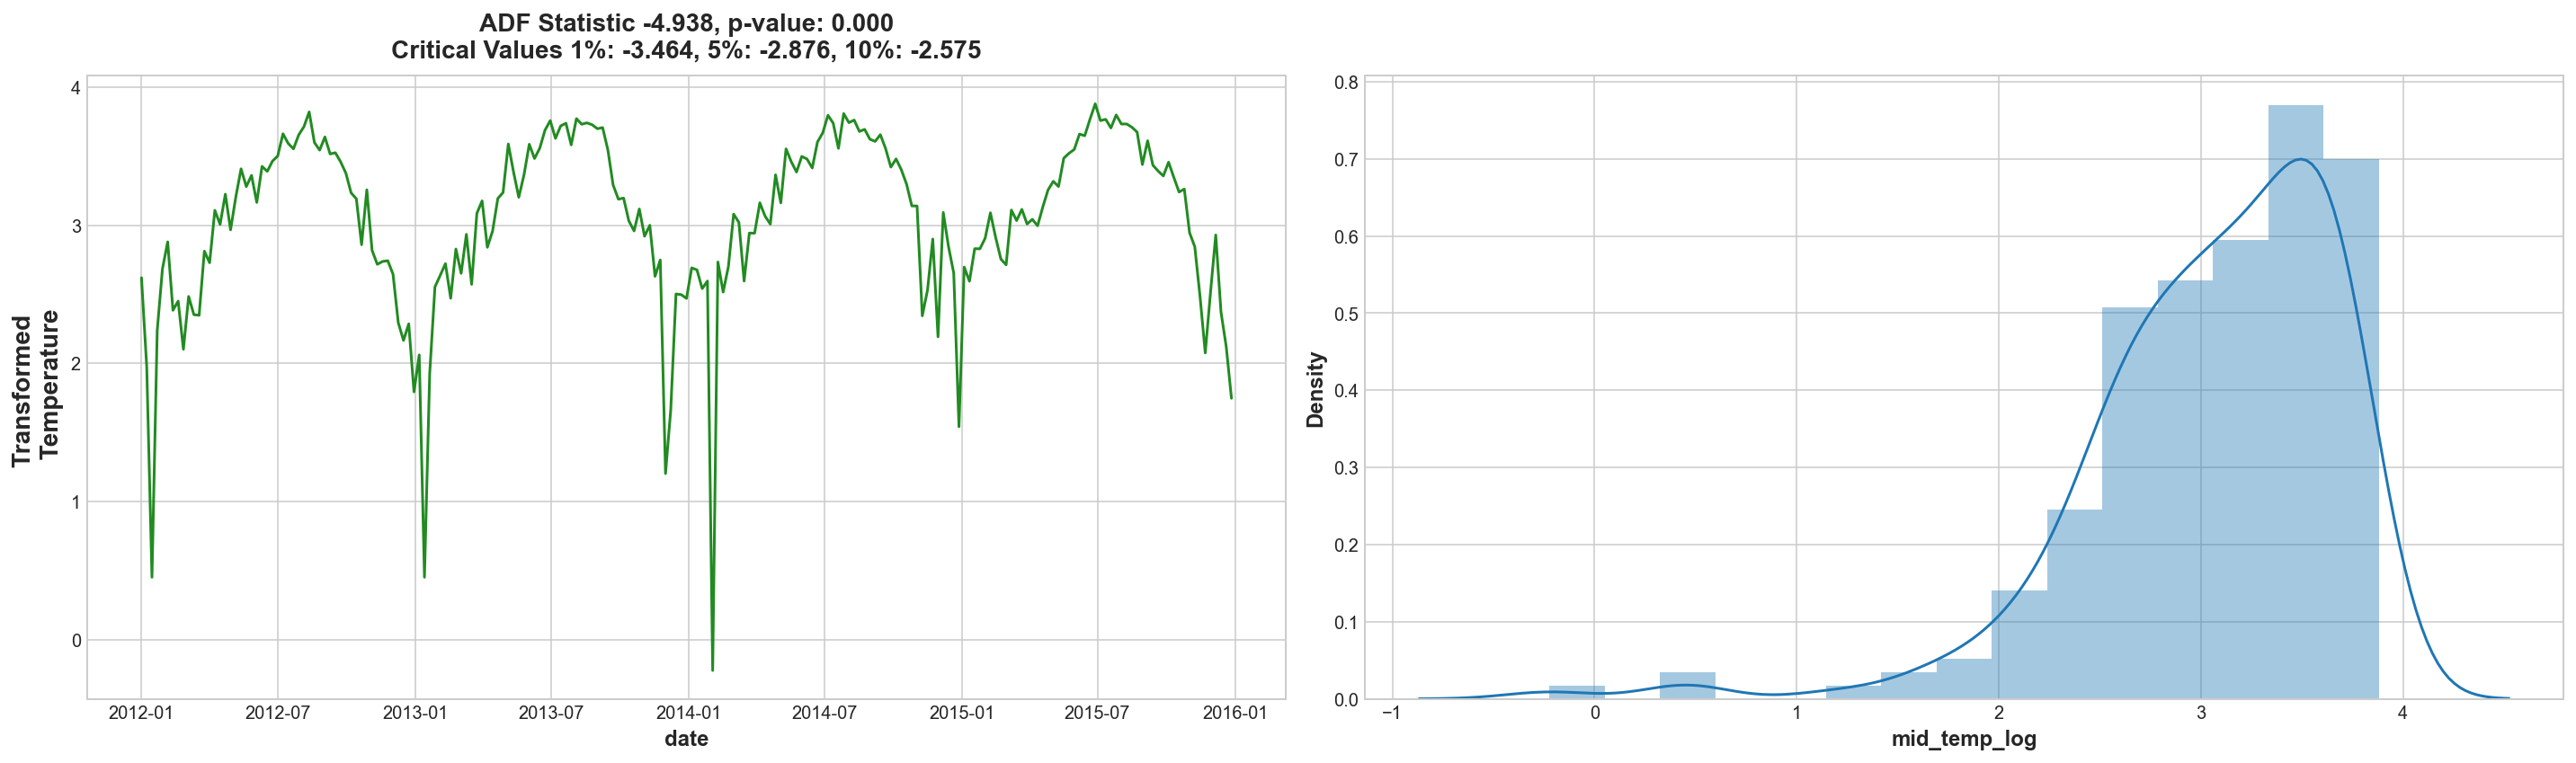

In [124]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['mid_temp_log'] = np.log(abs(df['mid_temp']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['mid_temp_log'], 'Transformed \n Temperature', ax[0])

sns.distplot(df['mid_temp_log'], ax=ax[1])

##  Differencing

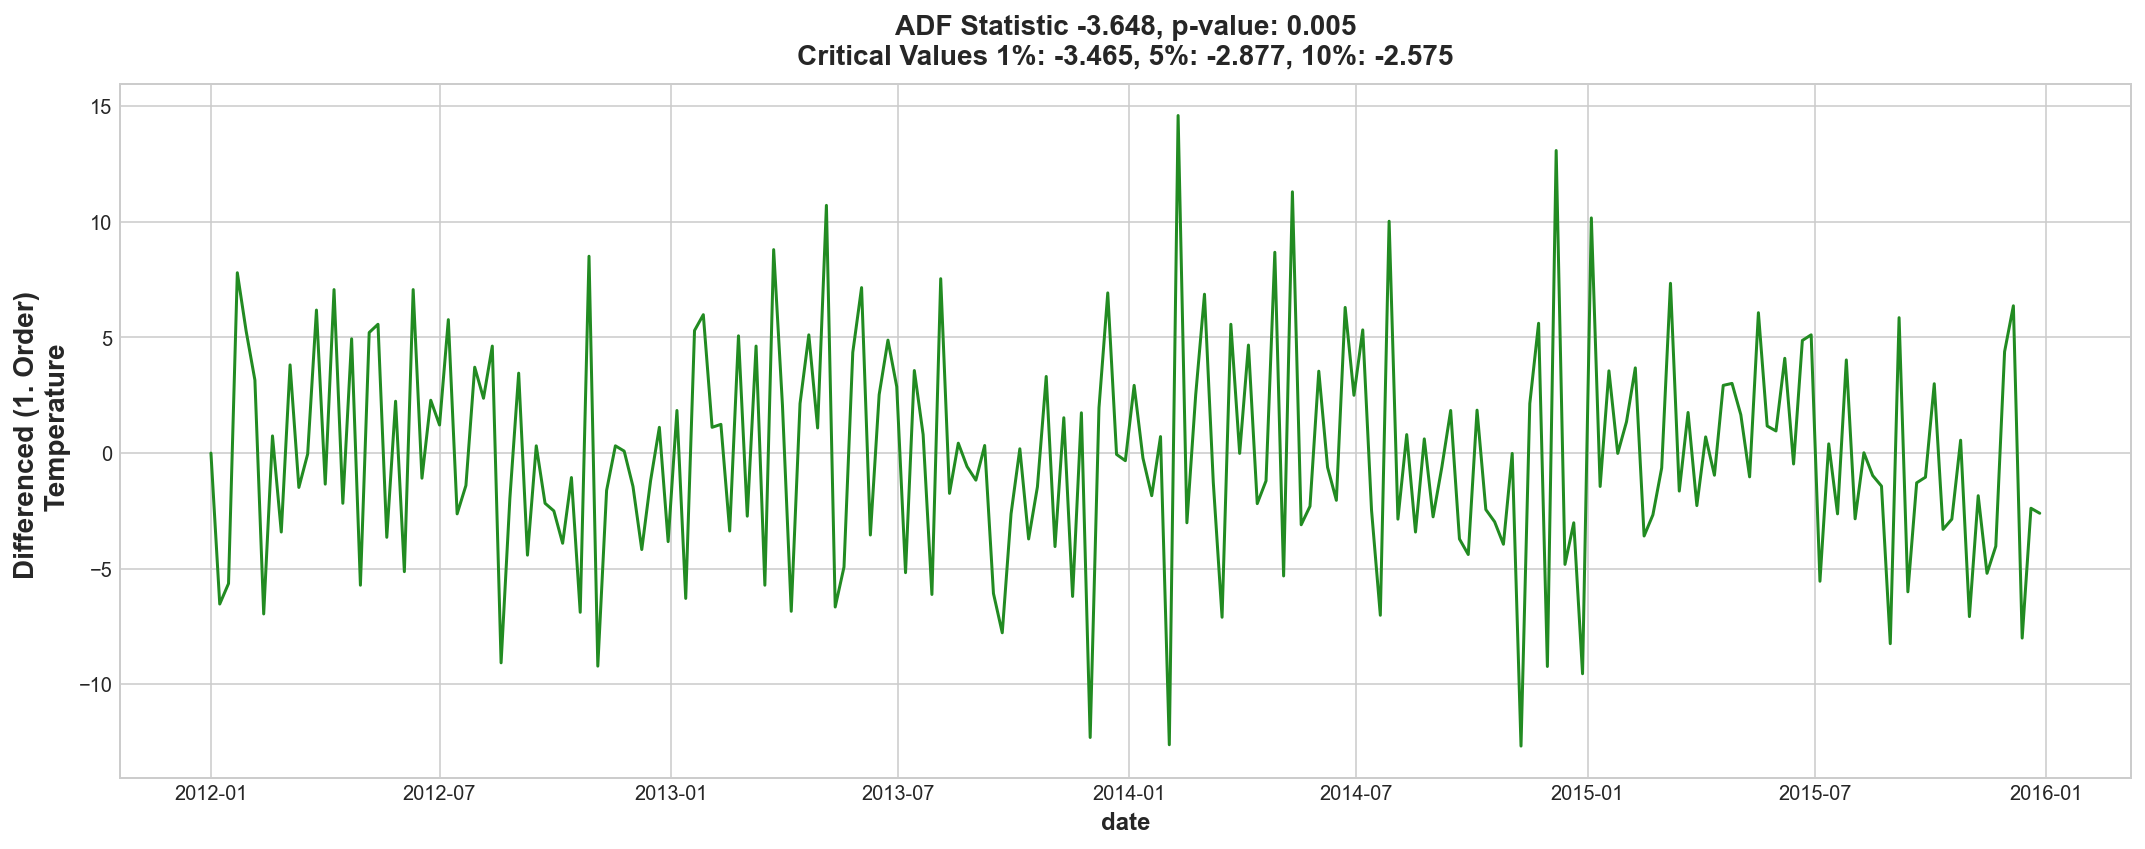

In [125]:
# First Order Differencing
ts_diff = np.diff(df['mid_temp'])
df['mid_temp_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['mid_temp_diff_1'], 'Differenced (1. Order) \n Temperature', ax)

# Feature Engineering

In [126]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

date  year  month  day  day_of_year  week_of_year  quarter  season
0 2012-01-01  2012      1    1            1            52        1       1
1 2012-01-08  2012      1    8            8             1        1       1
2 2012-01-15  2012      1   15           15             2        1       1
3 2012-01-22  2012      1   22           22             3        1       1
4 2012-01-29  2012      1   29           29             4        1       1

##  Encoding Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

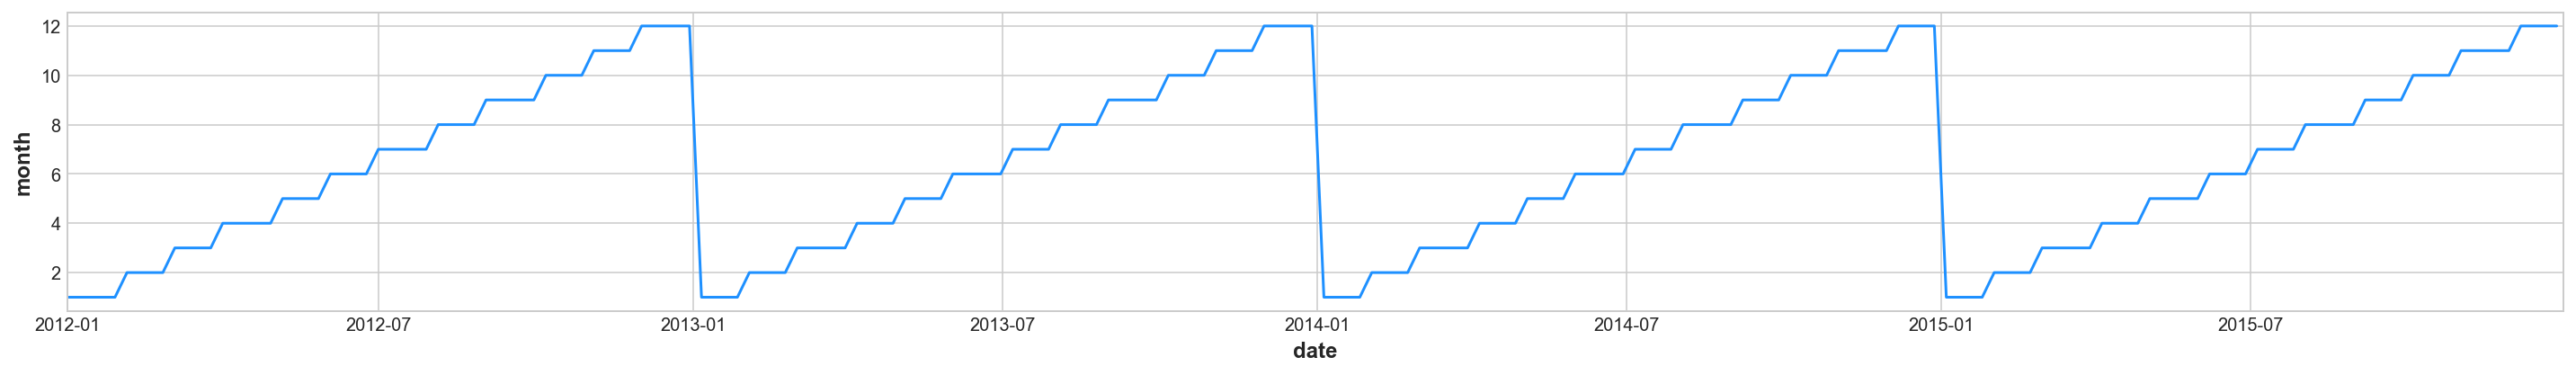

In [128]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2012, 1, 1), date(2015, 12, 31)])
plt.show()

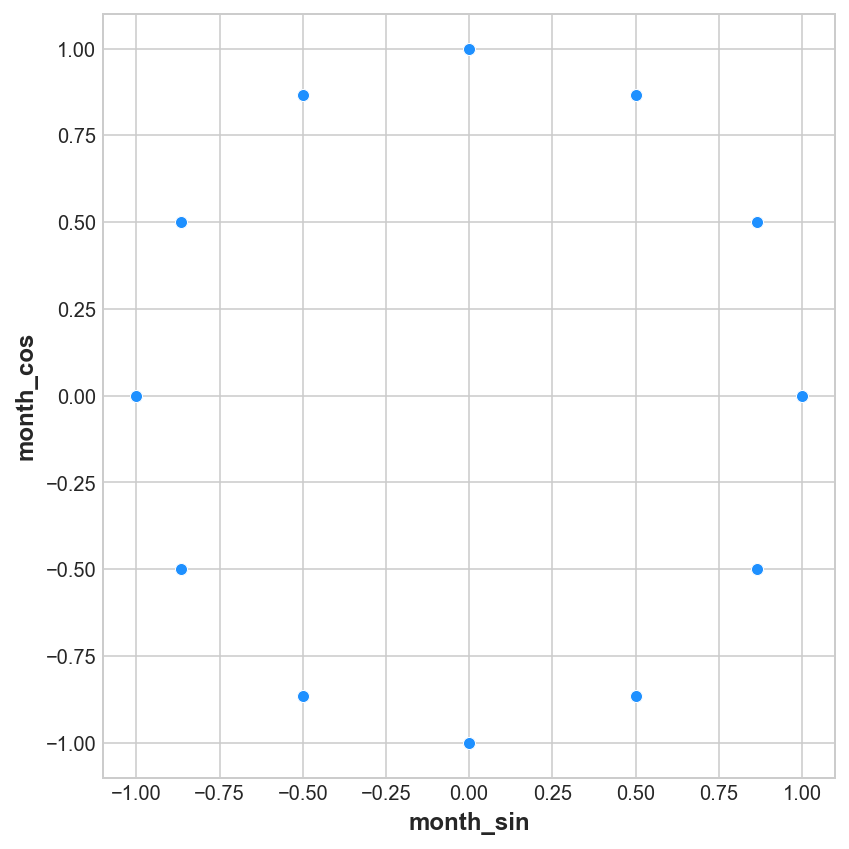

In [129]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

# TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.
Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.


In this case we are going to use function seasonal_decompose() from the statsmodels librar


In [153]:
df[['mid_temp', 'wind', 'precipitation']]

mid_temp      wind  precipitation
0    13.742857  3.828571       5.114286
1     7.214286  3.200000       1.342857
2     1.571429  4.414286       9.628571
3     9.371429  3.900000       3.942857
4    14.657143  4.057143       6.657143
..         ...       ...            ...
204  12.357143  3.671429       6.514286
205  18.728571  5.385714      18.842857
206  10.728571  4.028571       6.671429
207   8.342857  4.557143       7.242857
208   5.740000  2.740000       2.020000

[209 rows x 3 columns]

In [160]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'mid_temp', 'wind', 'precipitation'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

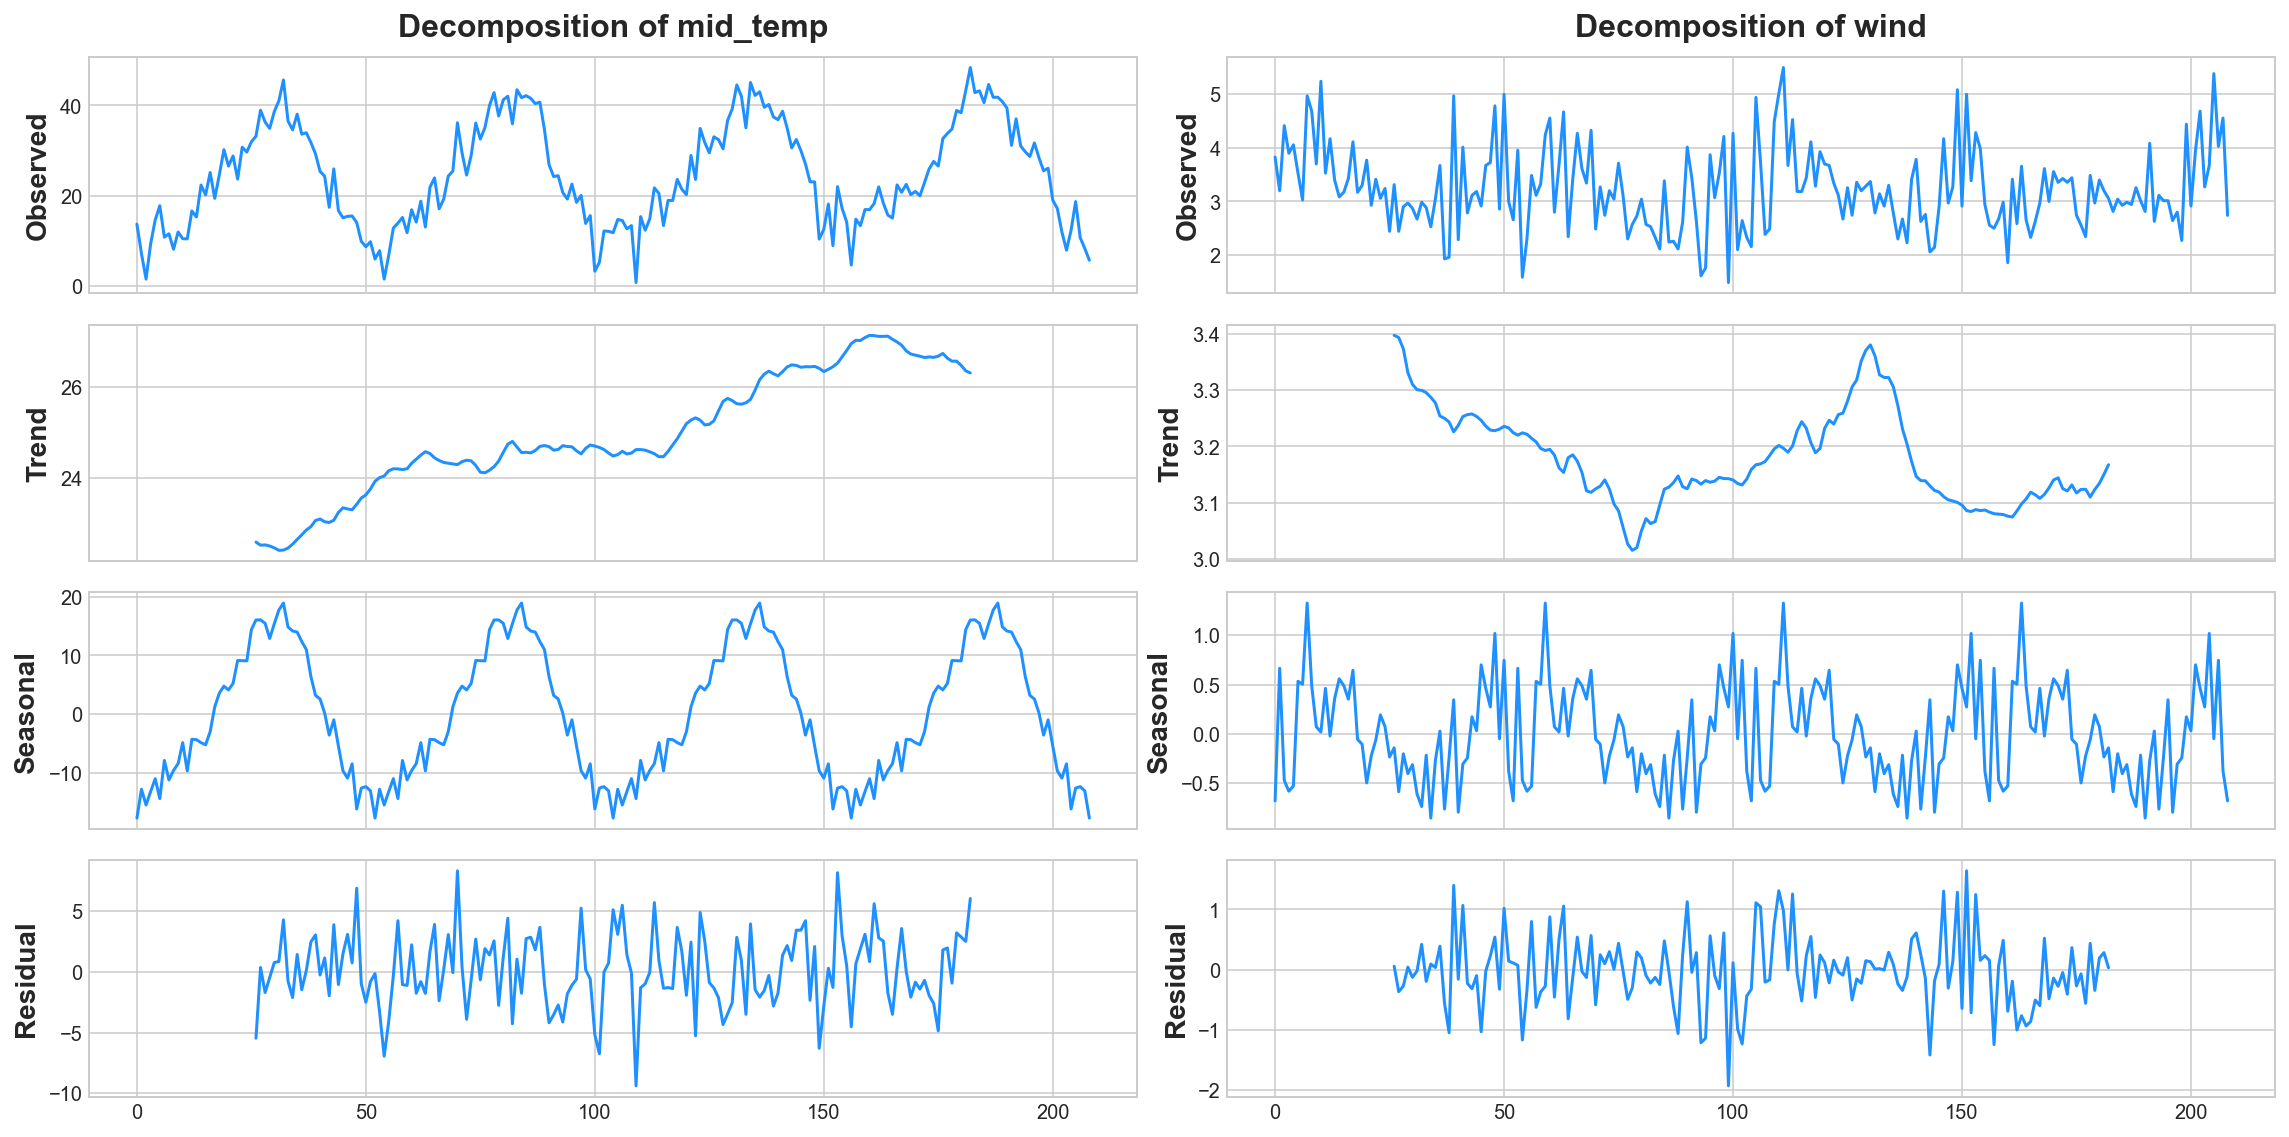

In [164]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['mid_temp', 'wind']):
    
    res = seasonal_decompose(df[column], period=52, model='additive')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

 ## Lag



We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.

Refrence  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [165]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)



# Exploratory Data Analysis 

Now, we are going to plot the data and try to extract some knowledge.

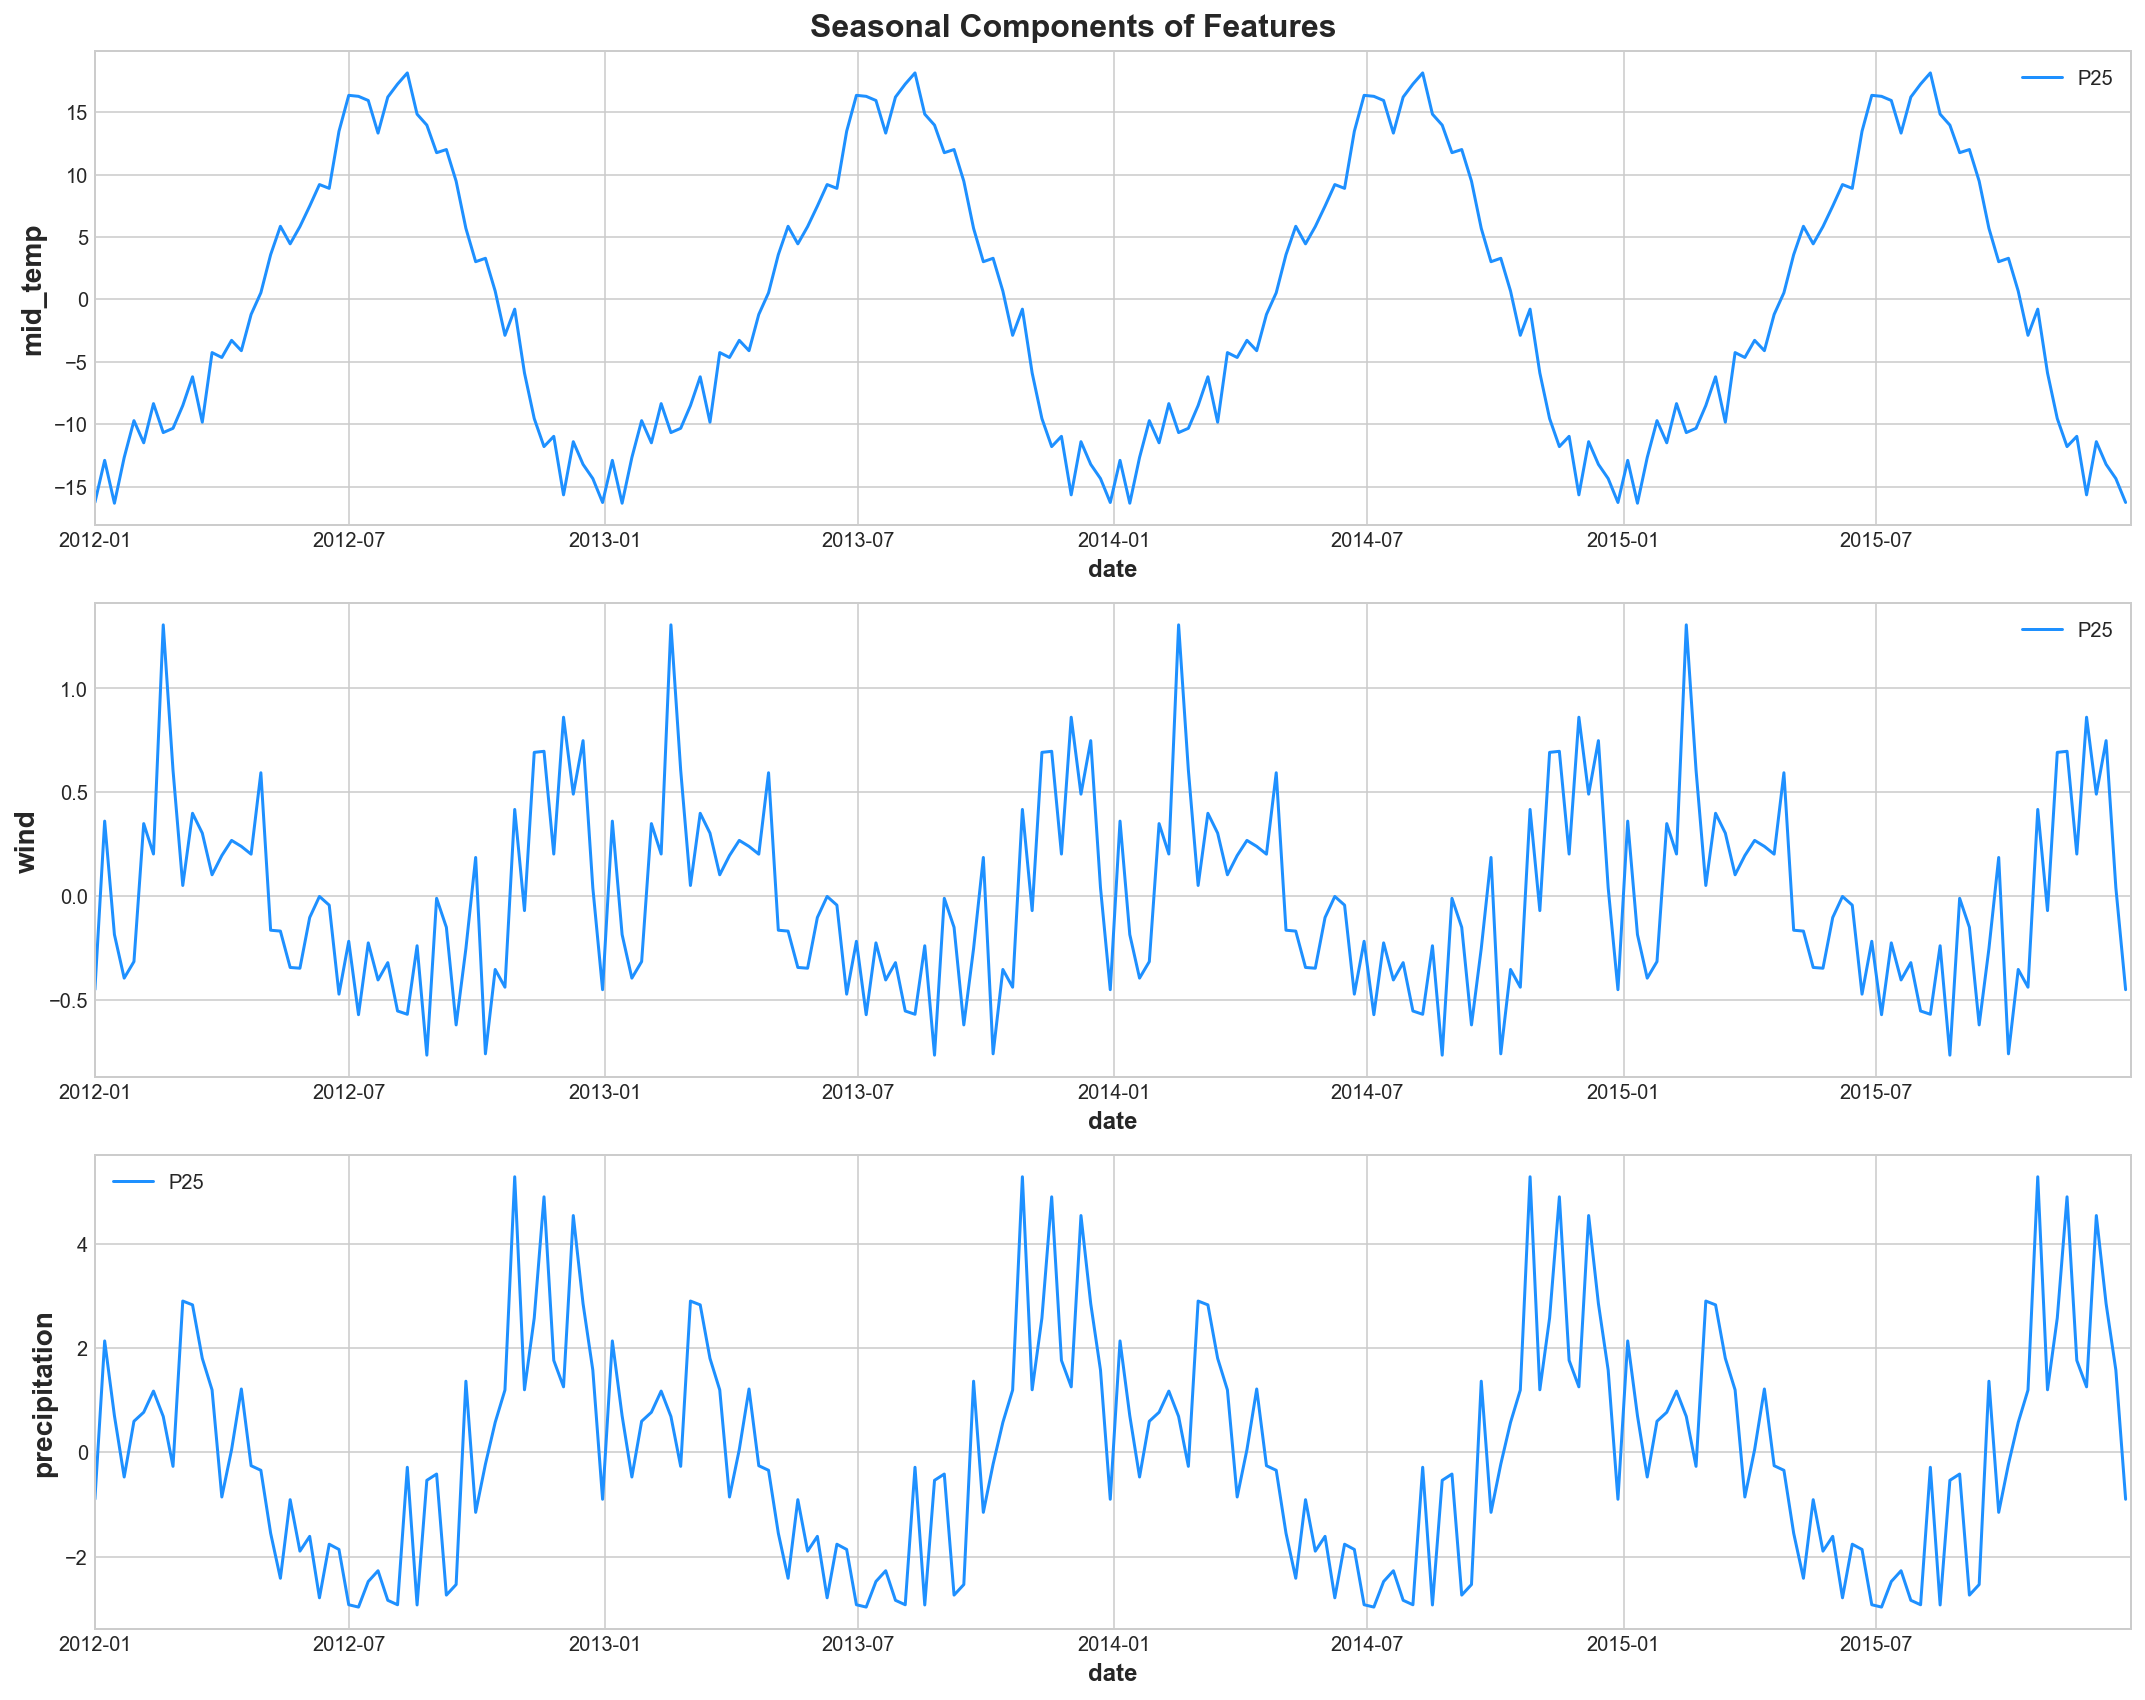

In [166]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2012, 1, 1), date(2015, 12, 31)])
    
plt.tight_layout()
plt.show()

As we can see:

Temperature: reaches its maximum around May/June and its minimum around November
Wind: reaches its maxmium around August and its minimum around January
Precipitation: reaches its minimum around July

In [167]:
core_columns

['mid_temp', 'wind', 'precipitation']

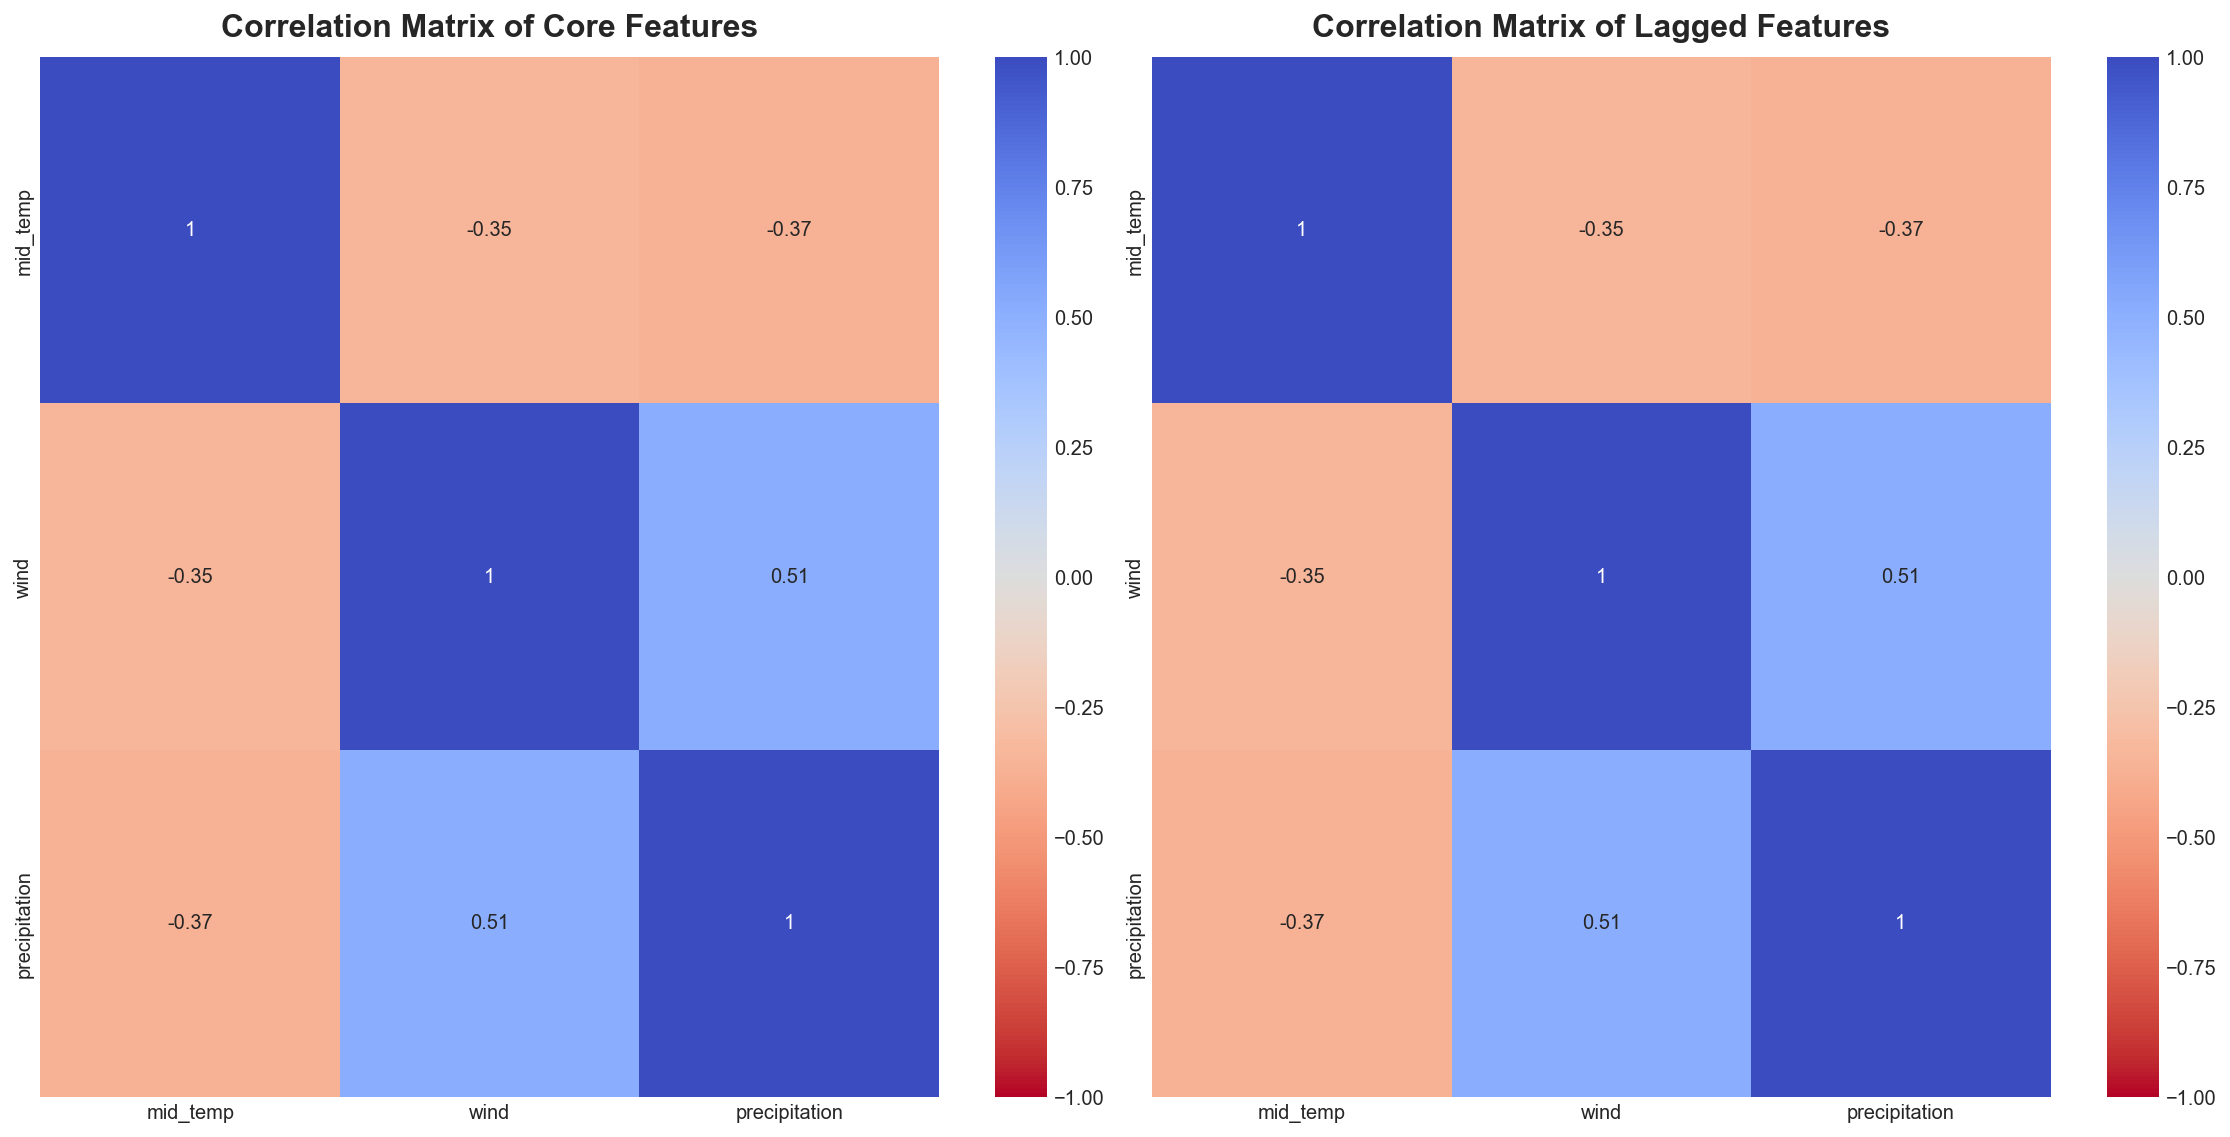

In [169]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'mid_temp',         
    'wind',
    'precipitation'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()


# Autocorrelation Analysis

Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.
Autocorrelation plots help in detecting seasonality.

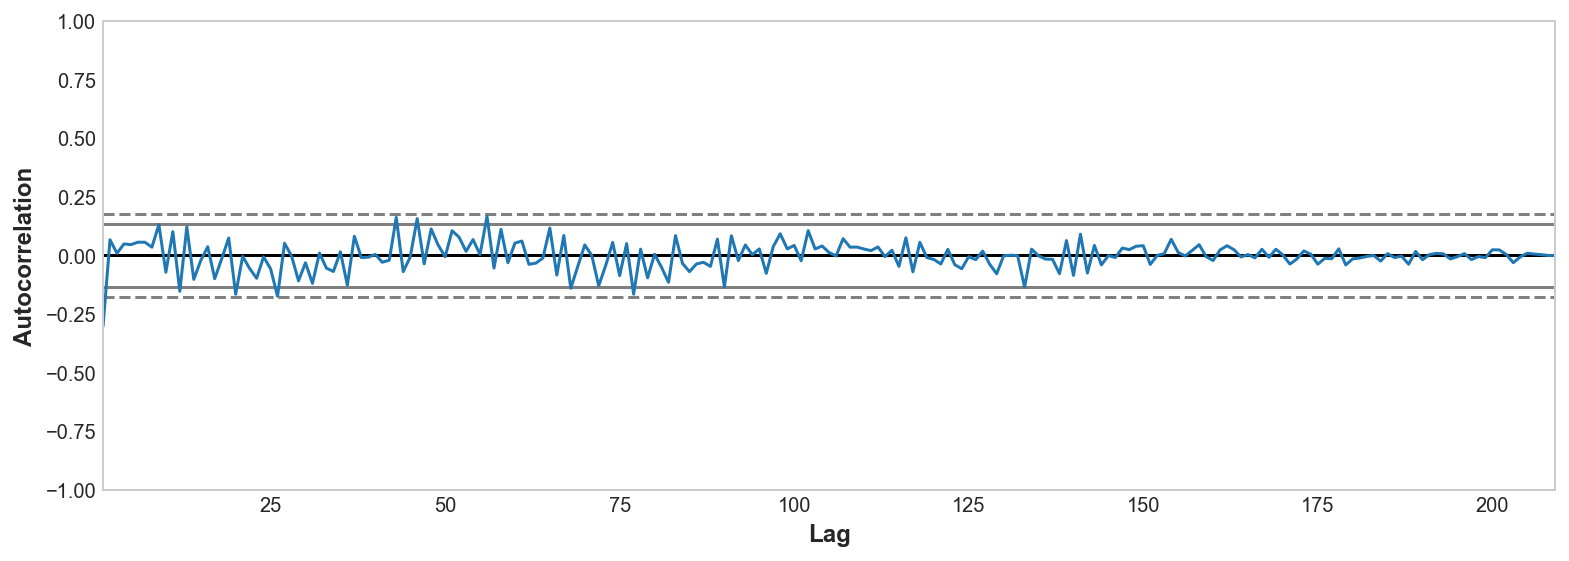

In [171]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['mid_temp_diff_1'])
plt.show()

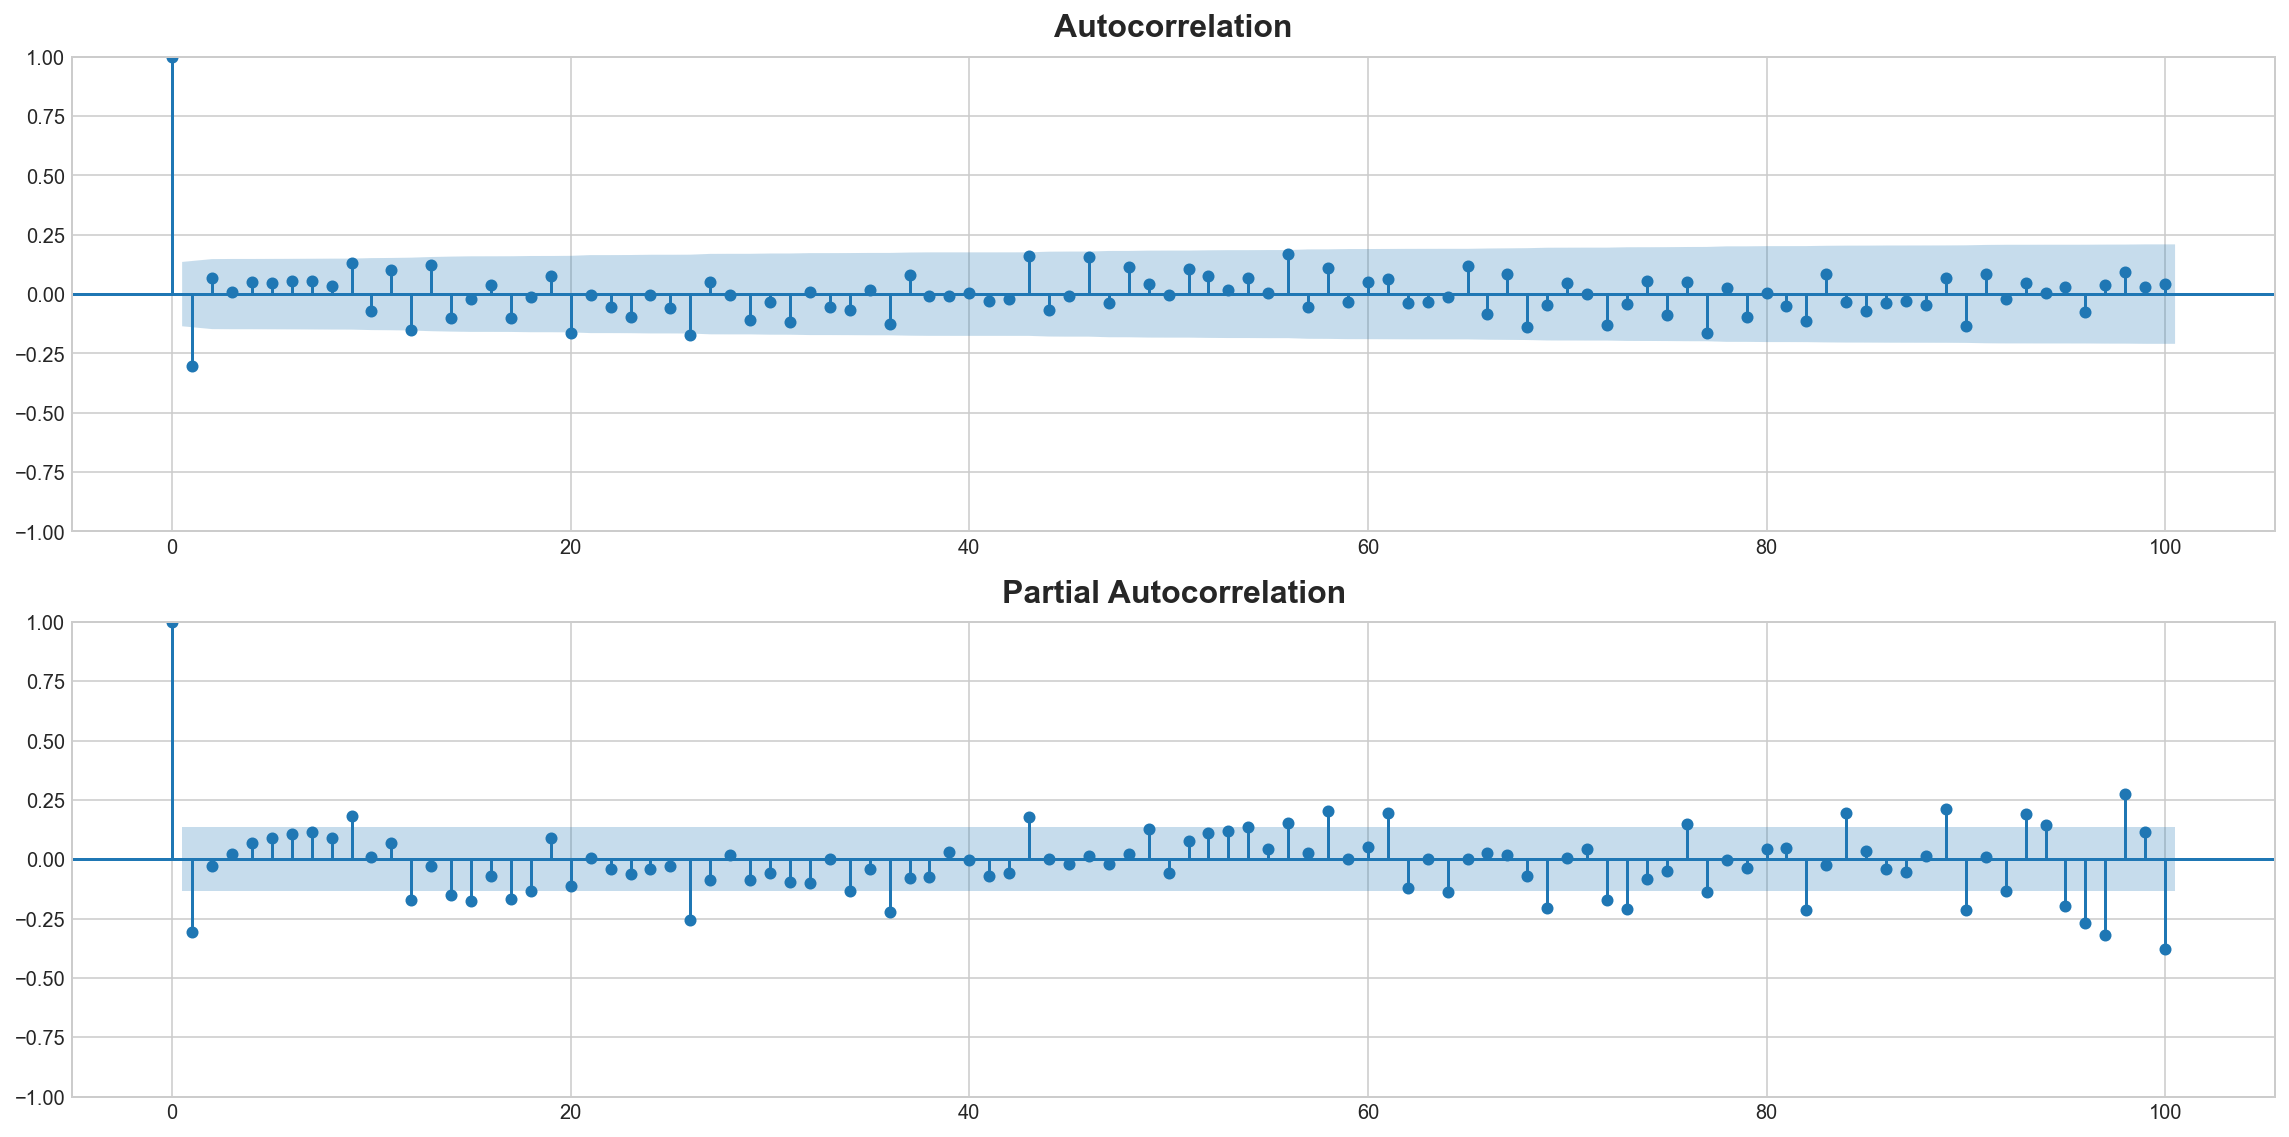

In [172]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['mid_temp_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['mid_temp_diff_1'], lags=100, ax=ax[1])

plt.show()

# Modelnig

## Cross Validation

In [173]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['mid_temp']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

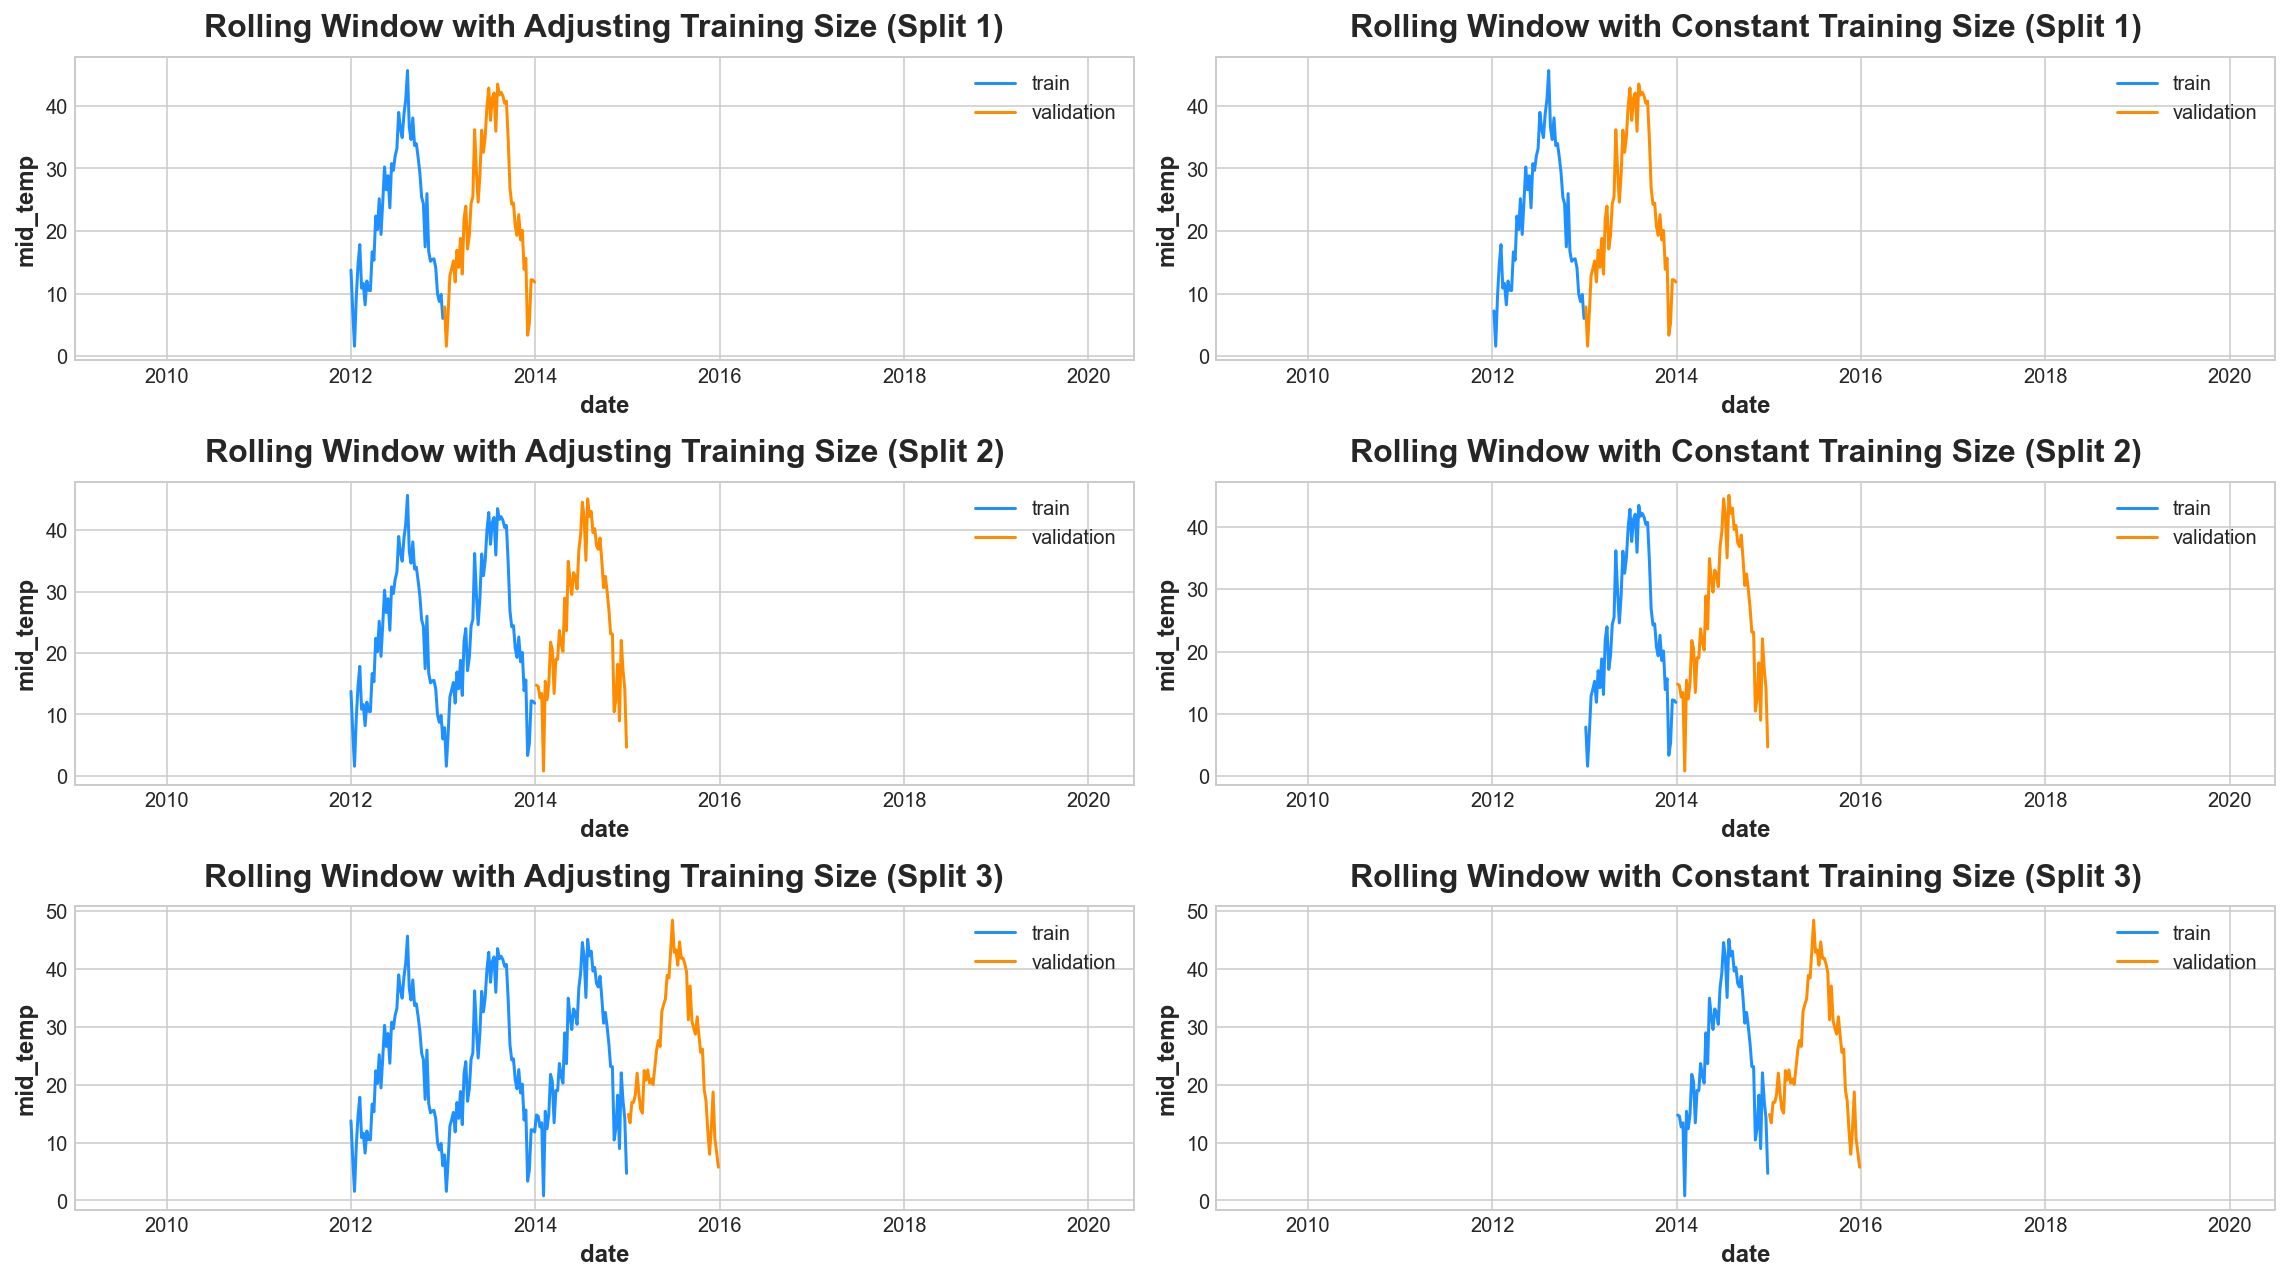

In [174]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

In [175]:
#The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.

## Models for Univariate Time Series

### Univariate time series

In [176]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'mid_temp']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

177 32


### Prophet

In [184]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from colorama import Fore

In [185]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

14:30:55 - cmdstanpy - INFO - Chain [1] start processing
14:30:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 4.798827622030838


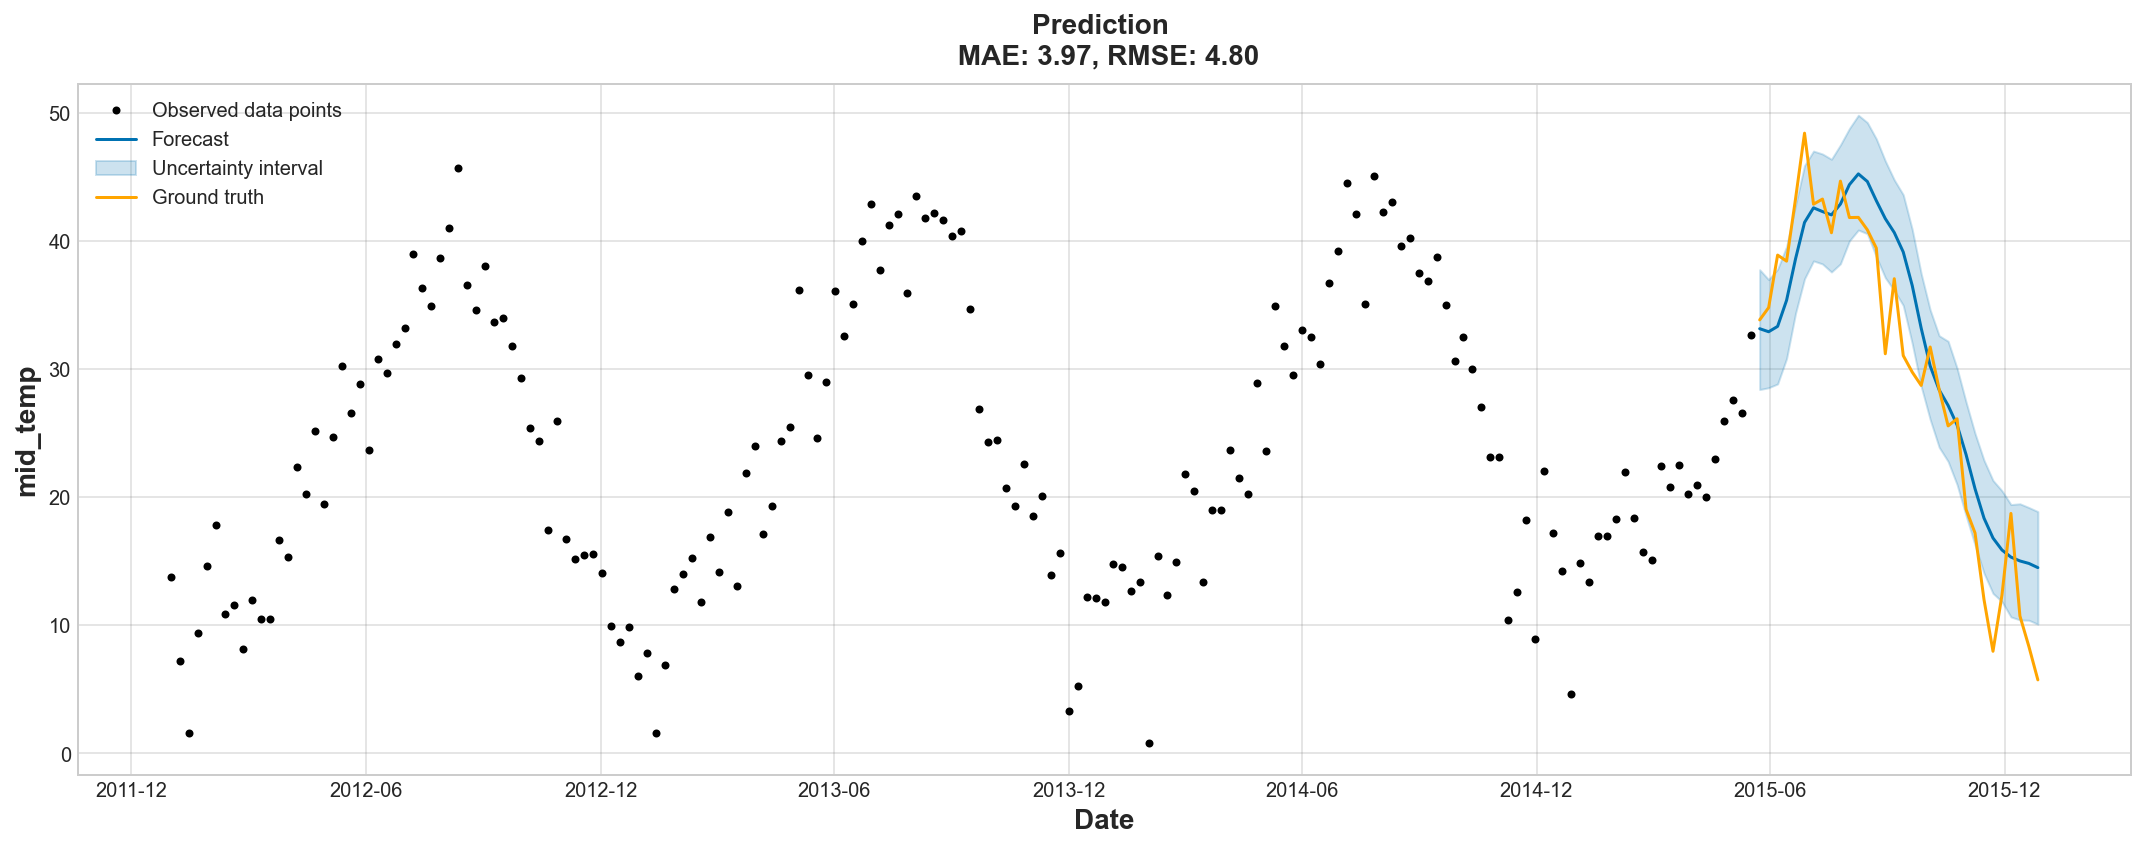

In [186]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='mid_temp', fontsize=14)

plt.show()


### ARIMA

Steps to analyze ARIMA
Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. 


Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.


Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this


Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.


Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).


Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [201]:
y_train

y
0    13.742857
1     7.214286
2     1.571429
3     9.371429
4    14.657143
..         ...
172  22.942857
173  25.957143
174  27.614286
175  26.585714
176  32.657143

[177 rows x 1 columns]

In [204]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(y_train, order=(1, 1, 1))  # Specify the order (p, d, q) of the ARIMA model
model_fit = model.fit()




In [209]:
# Make predictions on the validation set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_valid) - 1)



# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))


RMSE: 12.440624162119406


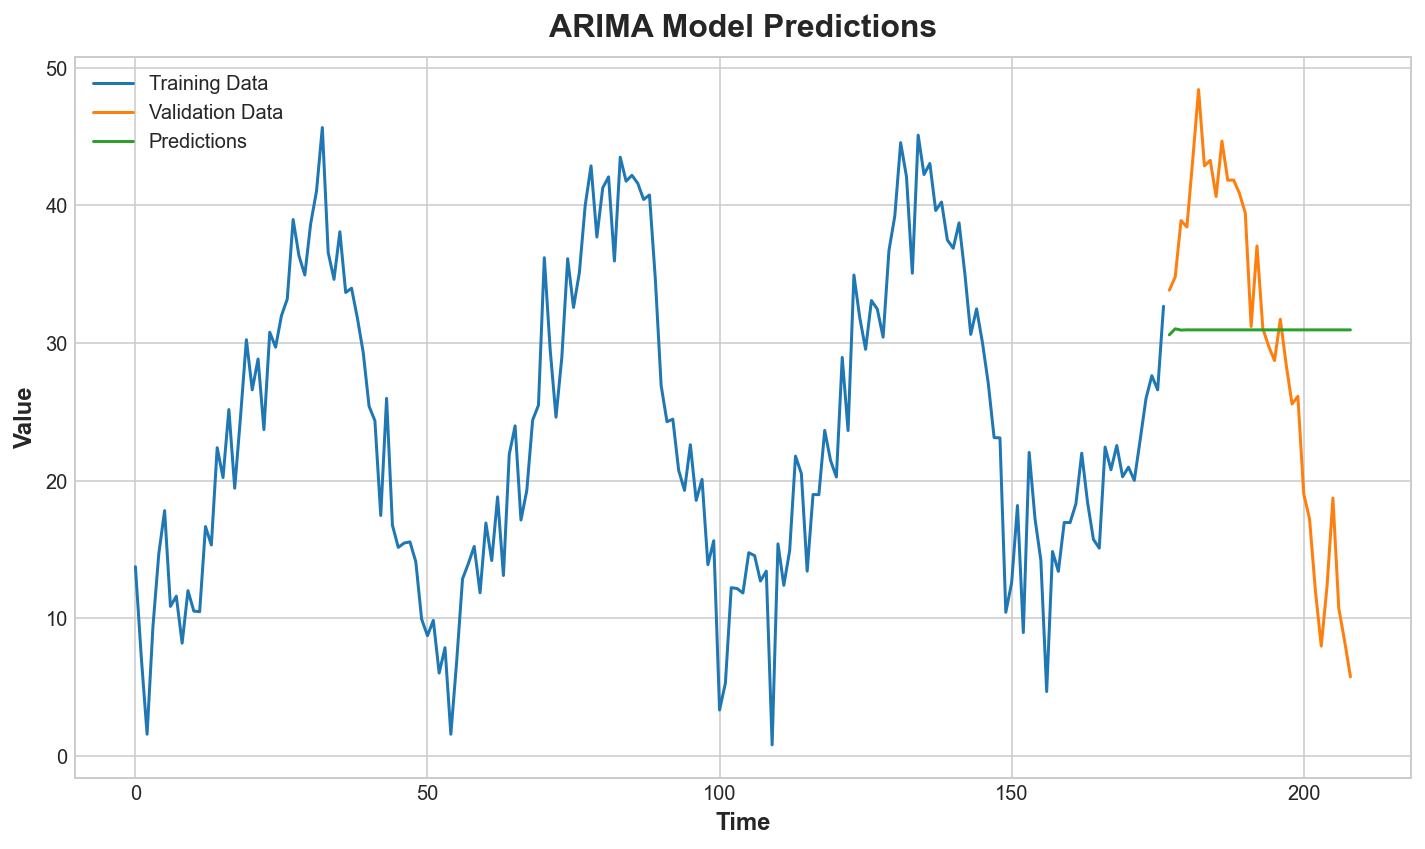

In [214]:
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Training Data')
plt.plot(y_valid, label='Validation Data')
plt.plot(y_pred, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()


In [216]:
x_valid

ds
177 2015-05-24
178 2015-05-31
179 2015-06-07
180 2015-06-14
181 2015-06-21
182 2015-06-28
183 2015-07-05
184 2015-07-12
185 2015-07-19
186 2015-07-26
187 2015-08-02
188 2015-08-09
189 2015-08-16
190 2015-08-23
191 2015-08-30
192 2015-09-06
193 2015-09-13
194 2015-09-20
195 2015-09-27
196 2015-10-04
197 2015-10-11
198 2015-10-18
199 2015-10-25
200 2015-11-01
201 2015-11-08
202 2015-11-15
203 2015-11-22
204 2015-11-29
205 2015-12-06
206 2015-12-13
207 2015-12-20
208 2015-12-27

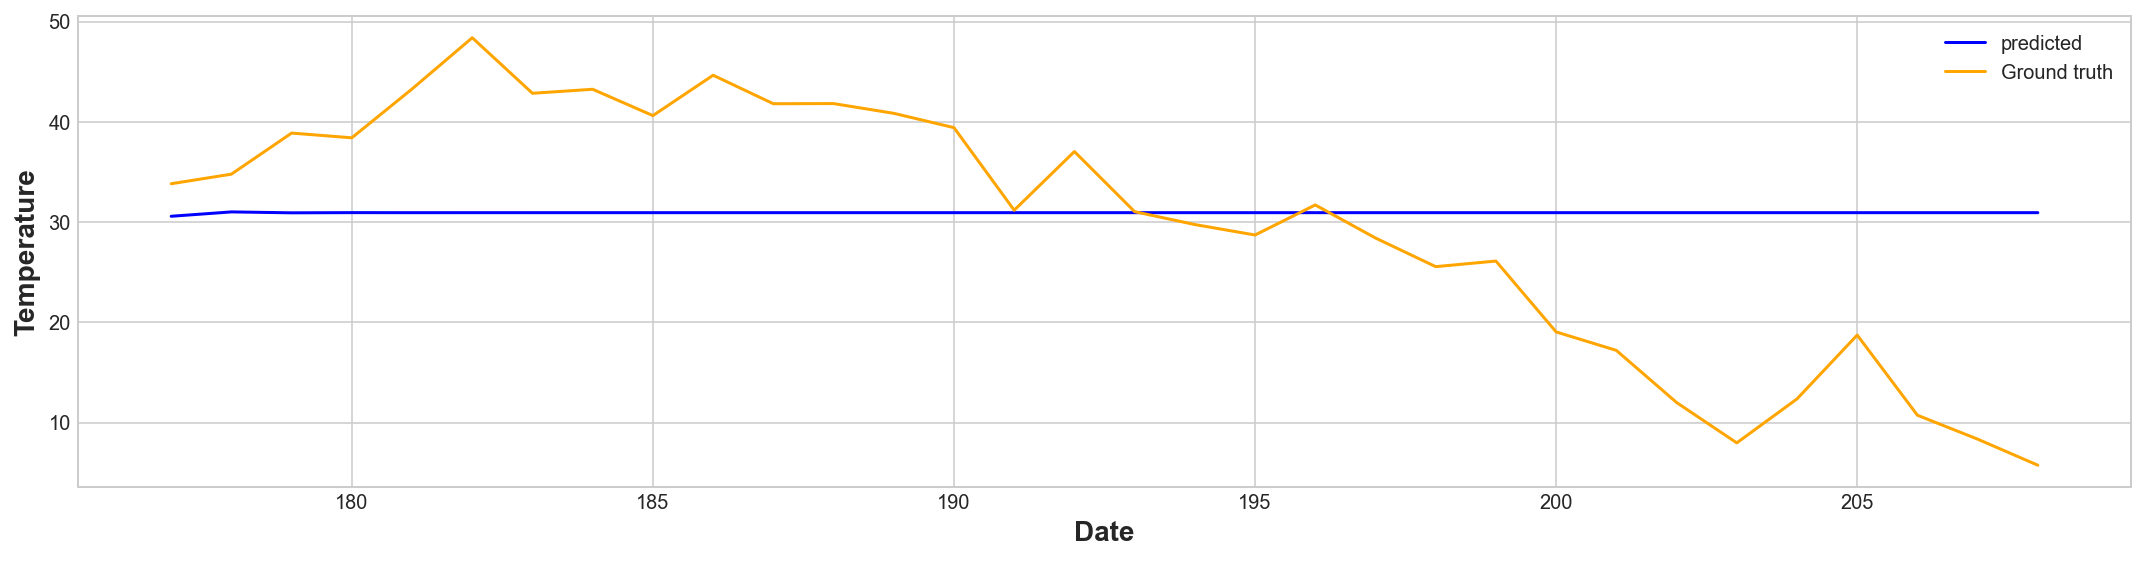

In [215]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Temperature', fontsize=14)

plt.show()


### Auto-ARIMA

In [217]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1047.076, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1063.757, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1045.545, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1046.181, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1061.841, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1047.011, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1049.004, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1043.715, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1045.206, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1045.271, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1044.393, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1047.198, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.357 seconds
                               SARIMAX Results                                
Dep. Vari

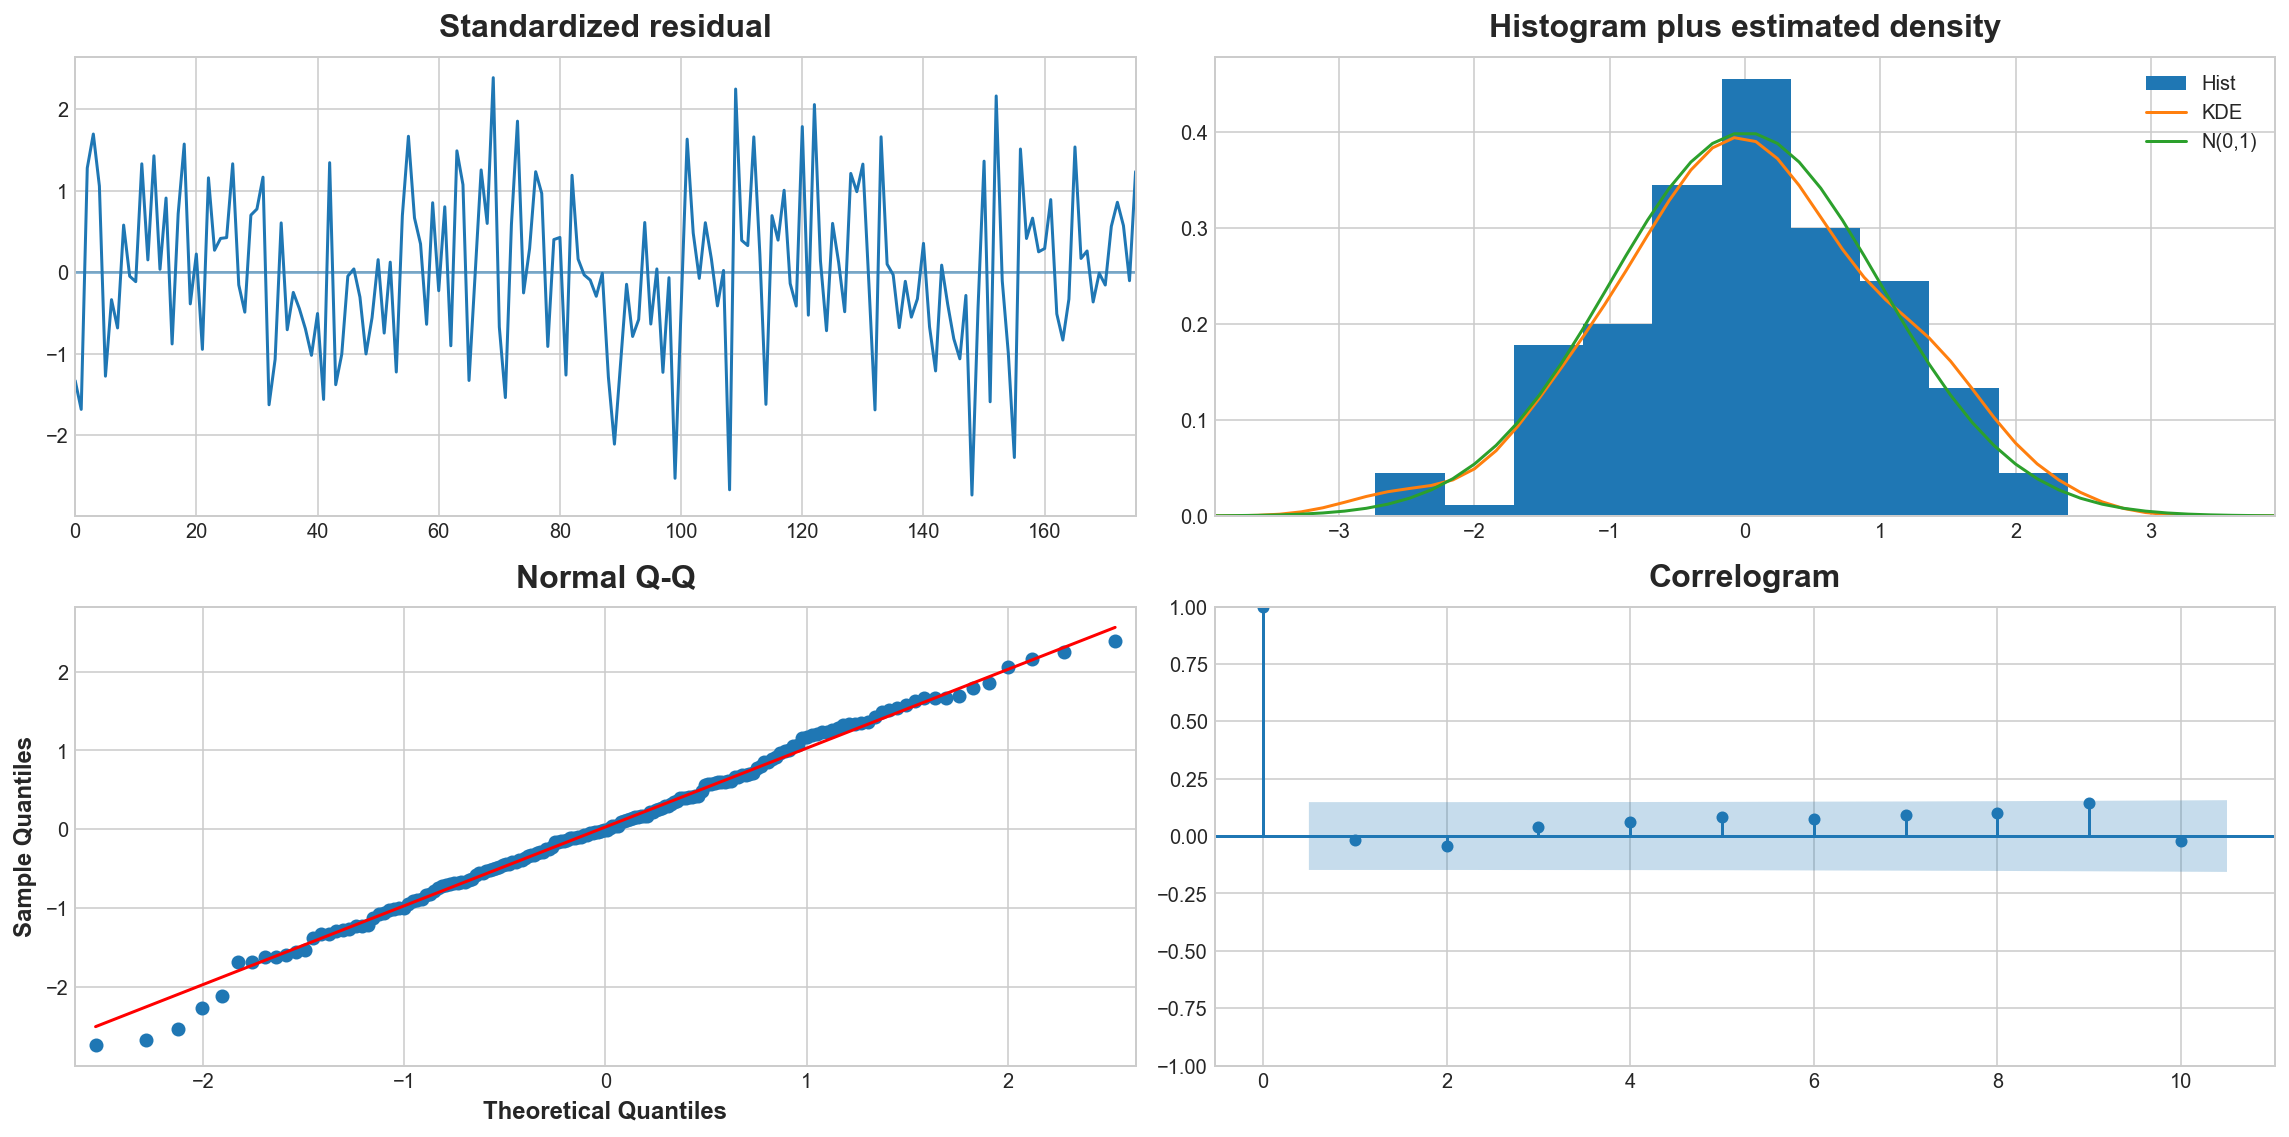

In [218]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-2, 2).

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution is not skewed for me).

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.




## LSTM

In [219]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.72809124],
       [-0.8652461 ],
       [-0.98379352],
       [-0.81992797],
       [-0.70888355],
       [-0.64255702],
       [-0.78871549],
       [-0.77310924],
       [-0.84483794],
       [-0.76470588]])

In [220]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

73 32


In [224]:
! pip install tensorflow

     |████████████████████████████████| 230.1 MB 49.3 MB/s eta 0:00:01   |█████▉                          | 41.9 MB 5.0 MB/s eta 0:00:38
     |████████████████████████████████| 440 kB 40.3 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 60.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 34.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 25.0 MB/s eta 0:00:01
     |████████████████████████████████| 317 kB 29.7 MB/s eta 0:00:01
     |████████████████████████████████| 17.7 MB 42.8 MB/s eta 0:00:01
  Created wheel for jax: filename=jax-0.4.10-py

    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
pandas-profiling 3.4.0 requires matplotlib<3.6,>=3.2, but you have matplotlib 3.7.1 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.


In [226]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

2023-05-19 15:33:00.652055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 15:33:00.653411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 15:33:00.654995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-05-19 15:33:00.881670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 15:33:00.883754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 15:33:00.885897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/73 [==========================>...] - ETA: 0s - loss: 0.0603

2023-05-19 15:33:04.203251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 15:33:04.204322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 15:33:04.206283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

73/73 [==============================] - 4s 13ms/step - loss: 0.0567 - val_loss: 0.0148
Epoch 2/5
73/73 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 3/5
73/73 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 4/5
73/73 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0106
Epoch 5/5
73/73 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0111
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            92672     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                        

In [227]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

2023-05-19 15:33:17.907710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 15:33:17.909582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 15:33:17.911597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 16ms/step
RMSE: 5.016461046631752


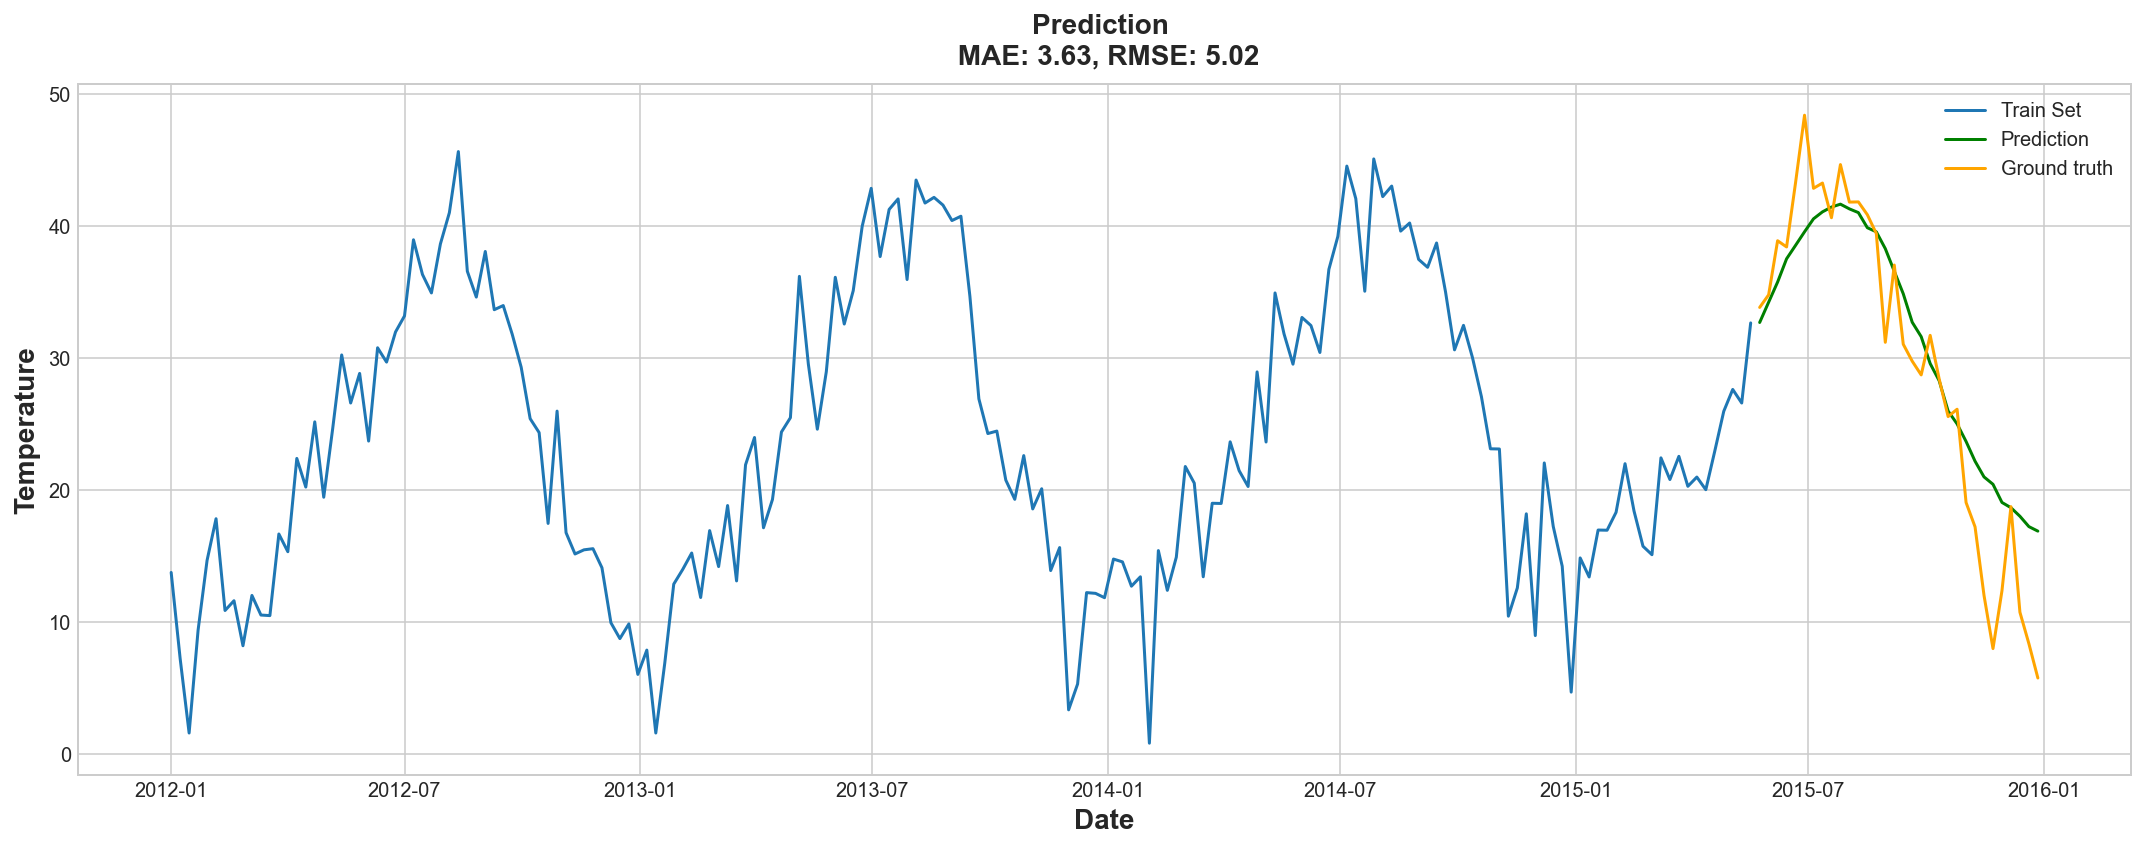

In [229]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Temperature', fontsize=14)

plt.show()


## Models for Multivariate Time Series

In [236]:
feature_columns = [
    'wind','precipitation']
target_column = ['mid_temp']

train_size = int(0.85 * len(df))



In [237]:
multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns


In [239]:
train = multivariate_df.iloc[:train_size, :]


In [241]:
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

ds          y      wind  precipitation
0 2012-01-01  13.742857  3.828571       5.114286
1 2012-01-08   7.214286  3.200000       1.342857
2 2012-01-15   1.571429  4.414286       9.628571
3 2012-01-22   9.371429  3.900000       3.942857
4 2012-01-29  14.657143  4.057143       6.657143

In [242]:



# Train the model
model = Prophet()
model.add_regressor('wind')
model.add_regressor('precipitation')


# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 4.710696710972815


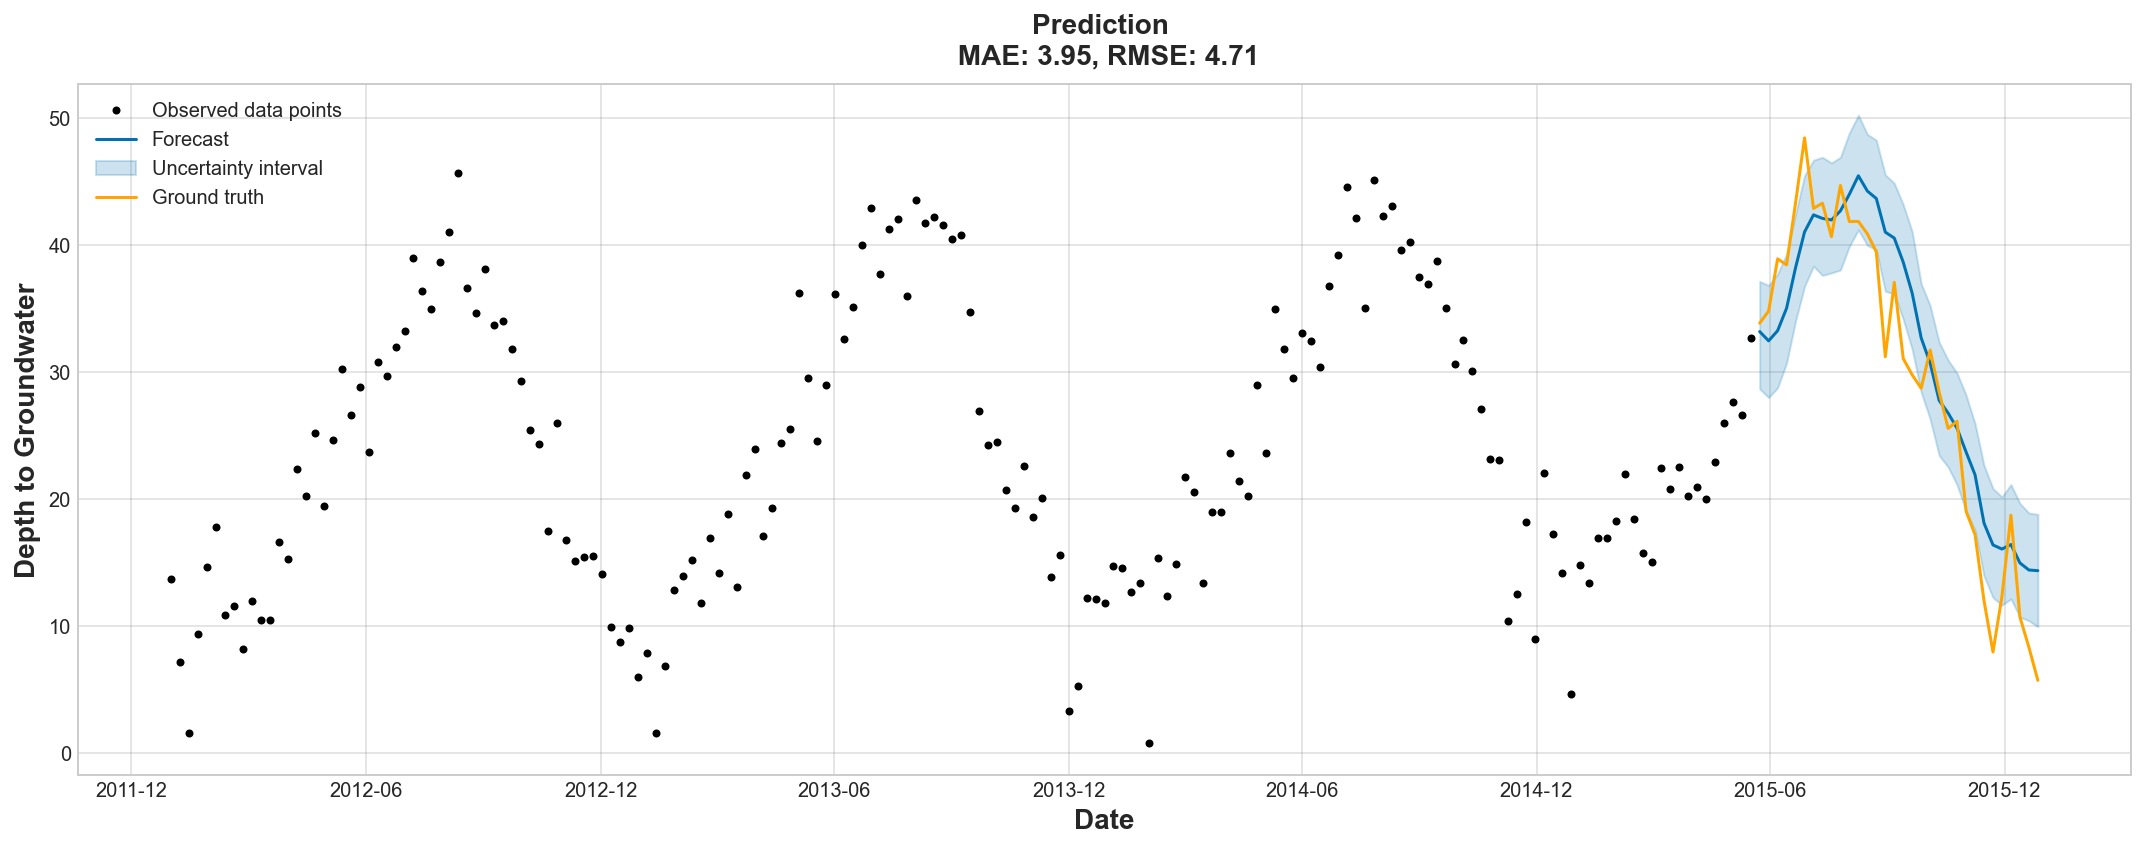

In [243]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# Conclusion

In [ ]:
The best results are taken from